In [1]:
import pandas as pd
import numpy as np

import math
import os

# # Make TensorFlow logs less verbose
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import flwr as fl
import tensorflow_probability as tfp

import keras
from sklearn.model_selection import train_test_split
from utils import model as mod
from flwr.common import NDArrays, Scalar
from scipy.stats import pearsonr
from typing import Dict, Optional, Tuple, List, Union
import typing
import random
import json
np.random.seed(2048)
tf.random.set_seed(2048)
random.seed(2048)
tf.keras.utils.set_random_seed(2048)



NUM_EPOCHS=10
BATCH_SIZE=16
path='resultsbn'
strat='FedBN'

2023-09-27 15:25:16.858021: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 15:25:16.860582: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 15:25:16.909838: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 15:25:16.913777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 15:25:18.975439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
!pwd

/rds/user/sc2427/hpc-work/Final/FL


In [3]:
data=pd.read_csv("all_data.csv")

In [4]:
df = pd.DataFrame(columns = data.columns)


In [5]:

dfs_to_concat = []

for i in range(250, 1000):
    mean_data = data.loc[data['Stamp'] == i].mean()
    dfs_to_concat.append(mean_data)

result_df = pd.concat(dfs_to_concat, axis=1).T.reset_index(drop=True)

In [6]:
data_new=result_df

In [7]:
data_new.shape

(750, 38)

In [8]:
y_labels=df.columns[-8:]

In [9]:
x_labels=df.columns[1:-8]

In [10]:
x=np.array(data_new[x_labels])

In [11]:
y=np.array(data_new[y_labels])

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1)

In [13]:
x_train.shape

(562, 29)

In [14]:
# y_train=y_train.reshape((1,y_train.shape[0],y_train.shape[1]))
y_train.shape

(562, 8)

In [15]:

model_eval = mod()
model_eval.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError() ])

2023-09-27 15:25:26.880650: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
def pcc(y_val, y_pred):
  temp={}
  for i in range(len(y_labels)):
    temp[y_labels[i]]=(pearsonr(y_val[:,i],y_pred[:,i])[0])
  return sum(list(temp.values()))/len(list(temp.values()))

In [17]:
class FlowerClient(fl.client.NumPyClient):

    def __init__(self, model,cid, x_train, y_train, x_val, y_val, path) -> None:
        self.model = model
        self.cid=cid
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val
        self.path=path

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=2)
        # loss, rmse = model.evaluate(self.x_val, self.y_val)
        loss,rmse=self.model.evaluate(self.x_val, self.y_val)

        # result["pr"].append(pr)


        try:
          data=pd.read_csv(f"{self.path}/result_{self.cid}.csv")
          data.drop(["Unnamed: 0"], axis=1, inplace=True)

        except:
          data=pd.DataFrame(columns=["round","Loss", "RMSE"])

        data=pd.concat([data,pd.Series([config['server_round'], loss, rmse ] , index=data.columns ).to_frame().T])
        data.to_csv(f"{self.path}/result_{self.cid}.csv")

        return loss, len(self.x_val), {"accuracy": rmse}

    def set_parameters(self, parameters: List[np.ndarray])-> None:
        self.model.train()
        keys = [k for k in self.model.state_dict().keys() if "bn" not in k]
        params_dict = zip(keys, parameters)
        state_dict = OrderedDict({k: tf.Tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=False)

In [18]:

#import pearsonr
def get_eval_fn(model, result,result_train):
    """Return an evaluation function for server-side evaluation."""

    # Load data and model here to avoid the overhead of doing it in `evaluate` itself


    # The `evaluate` function will be called after every round
    def evaluate(server_round: int, weights: fl.common.NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        model.set_weights(weights)  # Update model with the latest parameters
        loss, rmse = model.evaluate(x_test, y_test)
        loss_train,rmse_train=model.evaluate(x_train, y_train)
        result_train['Losses'].append(loss_train)
        result_train['rmse'].append(rmse_train)

        result["Losses"].append(loss)
        result["rmse"].append(rmse)
        # result["pr"].append(pr)
        for i in range(len(y_labels)):
          result["pearson"][y_labels[i]].append(pearsonr(y_test[:,i],model.predict(x_test)[:,i])[0])
          result_train['pearson'][y_labels[i]].append(pearsonr(y_train[:,i],model.predict(x_train)[:,i])[0])


        return loss, {"accuracy": rmse}

    return evaluate

In [19]:
model_eval.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 batch_normalization (Batch  (None, 16)                64        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 1016 (3.97 KB)
Trainable params: 952 (3.72

In [20]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

def evaluate_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

In [21]:
ray_init_args = {
            "num_gpus": 0,
            "num_cpus": 1
        }
client_res={"num_gpus": 0, "num_cpus": 1}

In [22]:
inital=mod()
#for clients from 2 to 10, run the strategy for 10 rounds each and create a list of results
results=[]
results_train=[]
# for i in range(5):
for i in range(2,11):
    try:
        os.mkdir(f"{path}/{i}")
    except:
        print()
    try:
        os.mkdir(f"{path}/{i}/{strat}")
    except:
        print()
    
    NUM_CLIENTS = i
    # losses=[]
    def client_fn(cid: str) -> fl.client.Client:
        # Create model
        model = mod()
        model.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError()])    
        partition_size = math.floor(len(x_train) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_train_cid = x_train[idx_from:idx_to]
        full_y_train_cid = y_train[idx_from:idx_to]
    
    
        partition_size = math.floor(len(x_test) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_test_cid = x_test[idx_from:idx_to]
        full_y_test_cid = y_test[idx_from:idx_to]
    
        # Create and return client
        return FlowerClient(model,cid, full_x_train_cid, full_y_train_cid, full_x_test_cid, full_y_test_cid, f"{path}/{i}/{strat}")


    
    
    result={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    result_train={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    try:
        del strategy
    except:
        print('starting')
    # Create FedAvg strategy
    strategy = fl.server.strategy.FedAvg(
      min_fit_clients=i,  # Never sample less than 10 clients for training
      evaluate_fn=get_eval_fn(model_eval, result,result_train),
      on_fit_config_fn=fit_config,
      on_evaluate_config_fn=evaluate_config,
      initial_parameters=fl.common.ndarrays_to_parameters(inital.get_weights()),
    )
    
    # Start simulation
    fl.simulation.start_simulation(
      client_fn=client_fn,
      num_clients=NUM_CLIENTS,
      config=fl.server.ServerConfig(num_rounds=10),
      strategy=strategy,
      ray_init_args=ray_init_args,
      client_resources=client_res,
    )
    results.append(result)
    results_train.append(result_train)
    # print(result)
    # try:
    #     data=pd.read_csv(f"{path}/combine_random{result['clients']}.csv")
    #     data.drop(["Unnamed: 0"], axis=1, inplace=True)
        
    # except:
    #     data=pd.DataFrame(columns=["Method", "Loss_Task1", "RMSE_Task1"])
    # data=pd.concat([data,pd.Series(["FedAvgEWC_Aug", result['Losses'][-1],result['rmse'][-1]] , index=data.columns ).to_frame().T])
    # data.to_csv(f"{path}/combine_random{result['clients']}.csv")



INFO flwr 2023-09-27 15:25:27,322 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)



starting


2023-09-27 15:25:31,008	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:25:31,193	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 15:25:32,569 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 4303

18/18 [==============================] - 0s 925us/step


INFO flwr 2023-09-27 15:25:34,993 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:25:34,994 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:25:34,995 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)
(pid=8604) 2023-09-27 15:25:35.689260: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=8604) 2023-09-27 15:25:35.691626: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=8604) 2023-09-27 15:25:35.748586: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=8604) 2023-09-27 15:25:35.749073: I tensorflow/core/platform/cpu_feature_guard.cc:1

(launch_and_fit pid=8604) Epoch 1/10
18/18 [==============================] - 1s 3ms/step - loss: 8.8564 - root_mean_squared_error: 2.9760
(launch_and_fit pid=8604) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 4.1245 - root_mean_squared_error: 2.0309
(launch_and_fit pid=8604) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5058 - root_mean_squared_error: 0.7112
(launch_and_fit pid=8604) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.3243 - root_mean_squared_error: 0.5695
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2540 - root_mean_squared_error: 0.5040
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2270 - root_mean_squared_error: 0.4764
(launch_and_fit pid=8604) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2310 - root_mean_squared_error: 0.4807
(launch_and_fit pid=8604) E

DEBUG flwr 2023-09-27 15:25:42,843 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-27 15:25:42,858 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


18/18 [==============================] - 0s 2ms/step - loss: 0.2533 - root_mean_squared_error: 0.5033
(launch_and_fit pid=8604) Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2415 - root_mean_squared_error: 0.4914
(launch_and_fit pid=8604) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2354 - root_mean_squared_error: 0.4852
(launch_and_fit pid=8604) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2286 - root_mean_squared_error: 0.4781
(launch_and_fit pid=8604) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:25:44,488 | server.py:119 | fit progress: (1, 0.2614651620388031, {'accuracy': 0.511336624622345}, 9.4931008531712)
DEBUG flwr 2023-09-27 15:25:44,488 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2624 - root_mean_squared_error: 0.5122


DEBUG flwr 2023-09-27 15:25:45,079 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-27 15:25:45,080 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:25:45,081 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2605 - root_mean_squared_error: 0.5104
(launch_and_fit pid=8604) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2516 - root_mean_squared_error: 0.5016
(launch_and_fit pid=8604) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2496 - root_mean_squared_error: 0.4996
(launch_and_fit pid=8604) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2416 - root_mean_squared_error: 0.4915
(launch_and_fit pid=8604) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2318 - root_mean_squared_error: 0.4815
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2444 - root_mean_squared_error: 0.4944
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2296 - root_mean_squared_error: 0.4792
(launch_and_fit pid=8604) Epoch 7/10
18/18 [======================

DEBUG flwr 2023-09-27 15:25:48,318 | server.py:232 | fit_round 2 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2281 - root_mean_squared_error: 0.4776
(launch_and_fit pid=8604) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2274 - root_mean_squared_error: 0.4769
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2231 - root_mean_squared_error: 0.4723
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2262 - root_mean_squared_error: 0.4756
(launch_and_fit pid=8604) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2294 - root_mean_squared_error: 0.4789
(launch_and_fit pid=8604) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2255 - root_mean_squared_error: 0.4749
(launch_and_fit pid=8604) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
(launch_and_fit pid=8604) Epoch 10/10
18/18 [===================

INFO flwr 2023-09-27 15:25:49,991 | server.py:119 | fit progress: (2, 0.23732993006706238, {'accuracy': 0.487165242433548}, 14.996330771129578)
DEBUG flwr 2023-09-27 15:25:49,992 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2420 - root_mean_squared_error: 0.4919


DEBUG flwr 2023-09-27 15:25:50,711 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:25:50,713 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2327 - root_mean_squared_error: 0.4824
(launch_and_fit pid=8604) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2489 - root_mean_squared_error: 0.4989
(launch_and_fit pid=8604) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2374 - root_mean_squared_error: 0.4873
(launch_and_fit pid=8604) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2183 - root_mean_squared_error: 0.4673
(launch_and_fit pid=8604) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2175 - root_mean_squared_error: 0.4664
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2255 - root_mean_squared_error: 0.4749
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2250 - root_mean_squared_error: 0.4744
(launch_and_fit pid=8604) Epoch 7/10
18/18 [======================

DEBUG flwr 2023-09-27 15:25:53,636 | server.py:232 | fit_round 3 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2651 - root_mean_squared_error: 0.5149
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2453 - root_mean_squared_error: 0.4953
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2315 - root_mean_squared_error: 0.4812
(launch_and_fit pid=8604) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2340 - root_mean_squared_error: 0.4838
(launch_and_fit pid=8604) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2478 - root_mean_squared_error: 0.4978
(launch_and_fit pid=8604) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2251 - root_mean_squared_error: 0.4744
(launch_and_fit pid=8604) Epoch 10/10
18/18 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 15:25:55,244 | server.py:119 | fit progress: (3, 0.2244292050600052, {'accuracy': 0.4737395942211151}, 20.249400104861706)
DEBUG flwr 2023-09-27 15:25:55,245 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
(launch_and_evaluate pid=8604) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x2b993b6cfd30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 [==============================] - 0s 2ms/step - loss: 0.2243 - root_mean_squared_error: 0.4736


DEBUG flwr 2023-09-27 15:25:55,952 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:25:55,954 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)
(launch_and_evaluate pid=8604) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x2b993bd819d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 [==============================] - 0s 2ms/step - loss: 0.2245 - root_mean_squared_error: 0.4739
(launch_and_fit pid=8604) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2375 - root_mean_squared_error: 0.4874
(launch_and_fit pid=8604) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2388 - root_mean_squared_error: 0.4886
(launch_and_fit pid=8604) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=8604) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2224 - root_mean_squared_error: 0.4715
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2237 - root_mean_squared_error: 0.4729
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2111 - root_mean_squared_error: 0.4595
(launch_and_fit pid=8604) Epoch 7/10
18/18 [======================

DEBUG flwr 2023-09-27 15:25:59,124 | server.py:232 | fit_round 4 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2450 - root_mean_squared_error: 0.4950
(launch_and_fit pid=8604) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2306 - root_mean_squared_error: 0.4802
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2232 - root_mean_squared_error: 0.4724
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2270 - root_mean_squared_error: 0.4764
(launch_and_fit pid=8604) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2247 - root_mean_squared_error: 0.4740
(launch_and_fit pid=8604) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2313 - root_mean_squared_error: 0.4809
(launch_and_fit pid=8604) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2339 - root_mean_squared_error: 0.4837
(launch_and_fit pid=8604) Epoch 10/10
18/18 [===================

INFO flwr 2023-09-27 15:26:00,729 | server.py:119 | fit progress: (4, 0.2183133214712143, {'accuracy': 0.4672401249408722}, 25.733993797097355)
DEBUG flwr 2023-09-27 15:26:00,730 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2141 - root_mean_squared_error: 0.4628


DEBUG flwr 2023-09-27 15:26:01,427 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:26:01,429 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2225 - root_mean_squared_error: 0.4717
(launch_and_fit pid=8604) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987
(launch_and_fit pid=8604) Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2223 - root_mean_squared_error: 0.4715
(launch_and_fit pid=8604) Epoch 3/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2280 - root_mean_squared_error: 0.4775
(launch_and_fit pid=8604) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2402 - root_mean_squared_error: 0.4901
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2224 - root_mean_squared_error: 0.4716
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=8604) Epoch 7/10
18/18 [======================

DEBUG flwr 2023-09-27 15:26:04,564 | server.py:232 | fit_round 5 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2179 - root_mean_squared_error: 0.4668
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4674
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666
(launch_and_fit pid=8604) Epoch 7/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2209 - root_mean_squared_error: 0.4700
(launch_and_fit pid=8604) Epoch 8/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2256 - root_mean_squared_error: 0.4749
(launch_and_fit pid=8604) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2046 - root_mean_squared_error: 0.4523
(launch_and_fit pid=8604) Epoch 10/10
18/18 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 15:26:06,368 | server.py:119 | fit progress: (5, 0.21825414896011353, {'accuracy': 0.46717679500579834}, 31.373880309052765)
DEBUG flwr 2023-09-27 15:26:06,370 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2164 - root_mean_squared_error: 0.4652


DEBUG flwr 2023-09-27 15:26:06,985 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:26:06,987 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2201 - root_mean_squared_error: 0.4691
(launch_and_fit pid=8604) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2380 - root_mean_squared_error: 0.4879
(launch_and_fit pid=8604) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2176 - root_mean_squared_error: 0.4664
(launch_and_fit pid=8604) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=8604) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2107 - root_mean_squared_error: 0.4590
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2141 - root_mean_squared_error: 0.4627
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2240 - root_mean_squared_error: 0.4733
(launch_and_fit pid=8604) Epoch 7/10
18/18 [======================

DEBUG flwr 2023-09-27 15:26:10,385 | server.py:232 | fit_round 6 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2237 - root_mean_squared_error: 0.4730
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2309 - root_mean_squared_error: 0.4806
(launch_and_fit pid=8604) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2216 - root_mean_squared_error: 0.4707
(launch_and_fit pid=8604) Epoch 8/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2345 - root_mean_squared_error: 0.4843
(launch_and_fit pid=8604) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2248 - root_mean_squared_error: 0.4741
(launch_and_fit pid=8604) Epoch 10/10
18/18 [==============================] - 0s 893us/step


INFO flwr 2023-09-27 15:26:12,023 | server.py:119 | fit progress: (6, 0.23084214329719543, {'accuracy': 0.48046034574508667}, 37.02790929796174)
DEBUG flwr 2023-09-27 15:26:12,024 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2416 - root_mean_squared_error: 0.4916


DEBUG flwr 2023-09-27 15:26:12,668 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:26:12,669 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2201 - root_mean_squared_error: 0.4691
(launch_and_fit pid=8604) Epoch 1/10
18/18 [==============================] - 1s 3ms/step - loss: 0.2311 - root_mean_squared_error: 0.4807
(launch_and_fit pid=8604) Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2295 - root_mean_squared_error: 0.4790
(launch_and_fit pid=8604) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2232 - root_mean_squared_error: 0.4724
(launch_and_fit pid=8604) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2254 - root_mean_squared_error: 0.4747
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2269 - root_mean_squared_error: 0.4764
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2218 - root_mean_squared_error: 0.4709
(launch_and_fit pid=8604) Epoch 7/10
18/18 [======================

DEBUG flwr 2023-09-27 15:26:15,719 | server.py:232 | fit_round 7 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2147 - root_mean_squared_error: 0.4633
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2127 - root_mean_squared_error: 0.4612
(launch_and_fit pid=8604) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2202 - root_mean_squared_error: 0.4693
(launch_and_fit pid=8604) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2242 - root_mean_squared_error: 0.4735
(launch_and_fit pid=8604) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2133 - root_mean_squared_error: 0.4619
(launch_and_fit pid=8604) Epoch 10/10
18/18 [==============================] - 0s 917us/step


INFO flwr 2023-09-27 15:26:17,272 | server.py:119 | fit progress: (7, 0.2360980063676834, {'accuracy': 0.4858991801738739}, 42.27700117183849)
DEBUG flwr 2023-09-27 15:26:17,272 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2415 - root_mean_squared_error: 0.4915


DEBUG flwr 2023-09-27 15:26:17,979 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:26:17,980 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2307 - root_mean_squared_error: 0.4803
(launch_and_fit pid=8604) Epoch 1/10
18/18 [==============================] - 1s 3ms/step - loss: 0.2340 - root_mean_squared_error: 0.4837
(launch_and_fit pid=8604) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553
(launch_and_fit pid=8604) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2125 - root_mean_squared_error: 0.4610
(launch_and_fit pid=8604) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2062 - root_mean_squared_error: 0.4541
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2162 - root_mean_squared_error: 0.4650
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2258 - root_mean_squared_error: 0.4752
(launch_and_fit pid=8604) Epoch 7/10
18/18 [======================

DEBUG flwr 2023-09-27 15:26:21,087 | server.py:232 | fit_round 8 received 2 results and 0 failures


18/18 [==============================] - 0s 3ms/step - loss: 0.2100 - root_mean_squared_error: 0.4582
(launch_and_fit pid=8604) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2155 - root_mean_squared_error: 0.4642
(launch_and_fit pid=8604) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2236 - root_mean_squared_error: 0.4729
(launch_and_fit pid=8604) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706
(launch_and_fit pid=8604) Epoch 10/10
18/18 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 15:26:22,658 | server.py:119 | fit progress: (8, 0.21452729403972626, {'accuracy': 0.4631709158420563}, 47.663146691862494)
DEBUG flwr 2023-09-27 15:26:22,660 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2158 - root_mean_squared_error: 0.4646


DEBUG flwr 2023-09-27 15:26:23,341 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:26:23,344 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2132 - root_mean_squared_error: 0.4617
(launch_and_fit pid=8604) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2387 - root_mean_squared_error: 0.4886
(launch_and_fit pid=8604) Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2232 - root_mean_squared_error: 0.4724
(launch_and_fit pid=8604) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=8604) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2173 - root_mean_squared_error: 0.4662
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2173 - root_mean_squared_error: 0.4661
(launch_and_fit pid=8604) Epoch 7/10
18/18 [======================

DEBUG flwr 2023-09-27 15:26:26,841 | server.py:232 | fit_round 9 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2150 - root_mean_squared_error: 0.4637
(launch_and_fit pid=8604) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.1934 - root_mean_squared_error: 0.4397
(launch_and_fit pid=8604) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2117 - root_mean_squared_error: 0.4601
(launch_and_fit pid=8604) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2009 - root_mean_squared_error: 0.4483
(launch_and_fit pid=8604) Epoch 10/10
18/18 [==============================] - 0s 929us/step


INFO flwr 2023-09-27 15:26:28,370 | server.py:119 | fit progress: (9, 0.2328822761774063, {'accuracy': 0.4825787842273712}, 53.375609477981925)
DEBUG flwr 2023-09-27 15:26:28,371 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2405 - root_mean_squared_error: 0.4904


DEBUG flwr 2023-09-27 15:26:29,037 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:26:29,039 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2253 - root_mean_squared_error: 0.4747
(launch_and_fit pid=8604) Epoch 1/10
18/18 [==============================] - 1s 3ms/step - loss: 0.2310 - root_mean_squared_error: 0.4806
(launch_and_fit pid=8604) Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2369 - root_mean_squared_error: 0.4868
(launch_and_fit pid=8604) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2062 - root_mean_squared_error: 0.4541
(launch_and_fit pid=8604) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2102 - root_mean_squared_error: 0.4584
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2150 - root_mean_squared_error: 0.4636
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2050 - root_mean_squared_error: 0.4528
(launch_and_fit pid=8604) Epoch 7/10
18/18 [======================

DEBUG flwr 2023-09-27 15:26:32,107 | server.py:232 | fit_round 10 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2331 - root_mean_squared_error: 0.4828
(launch_and_fit pid=8604) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2094 - root_mean_squared_error: 0.4576
(launch_and_fit pid=8604) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2131 - root_mean_squared_error: 0.4616
(launch_and_fit pid=8604) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666
(launch_and_fit pid=8604) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=8604) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2201 - root_mean_squared_error: 0.4691
(launch_and_fit pid=8604) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:26:33,818 | server.py:119 | fit progress: (10, 0.22212398052215576, {'accuracy': 0.47130030393600464}, 58.82364350371063)
DEBUG flwr 2023-09-27 15:26:33,819 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797


DEBUG flwr 2023-09-27 15:26:34,449 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-09-27 15:26:34,451 | server.py:147 | FL finished in 59.45593336503953
INFO flwr 2023-09-27 15:26:34,453 | app.py:218 | app_fit: losses_distributed [(1, 0.2614651918411255), (2, 0.23732995241880417), (3, 0.22442921996116638), (4, 0.2183133214712143), (5, 0.21825415641069412), (6, 0.23084214329719543), (7, 0.2360980212688446), (8, 0.21452730149030685), (9, 0.23288226127624512), (10, 0.22212398797273636)]
INFO flwr 2023-09-27 15:26:34,455 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:26:34,455 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:26:34,456 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2614651620388031), (2, 0.23732993006706238), (3, 0.2244292050600052), (4, 0.2183133214712143), (5, 0.21825414896011353), (6, 0.23084214329719543), (7, 0.2360980063676834), (8, 0.21452729403972626), (


3/3 [==============================] - 0s 2ms/step - loss: 0.2142 - root_mean_squared_error: 0.4628


2023-09-27 15:26:40,627	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:26:40,817	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 15:26:42,114 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 4327

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:26:43,681 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:26:43,682 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:26:43,683 | server.py:218 | fit_round 1: strategy sampled 3 clients (out of 3)
(pid=45021) 2023-09-27 15:26:44.660322: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=45021) 2023-09-27 15:26:44.662736: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=45021) 2023-09-27 15:26:44.720767: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=45021) 2023-09-27 15:26:44.721330: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=45021) Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 9.2675 - root_mean_squared_error: 3.0443
(launch_and_fit pid=45021) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 6.5993 - root_mean_squared_error: 2.5689
(launch_and_fit pid=45021) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 2.9757 - root_mean_squared_error: 1.7250
(launch_and_fit pid=45021) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.5119 - root_mean_squared_error: 0.7155
(launch_and_fit pid=45021) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.4162 - root_mean_squared_error: 0.6451
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2760 - root_mean_squared_error: 0.5254
(launch_and_fit pid=45021) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2644 - root_mean_squared_error: 0.5142
(launch_and_fit pid=

DEBUG flwr 2023-09-27 15:26:54,931 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-27 15:26:54,956 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


12/12 [==============================] - 1s 2ms/step - loss: 9.3650 - root_mean_squared_error: 3.0602
(launch_and_fit pid=45021) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 6.7227 - root_mean_squared_error: 2.5928
(launch_and_fit pid=45021) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 3.0954 - root_mean_squared_error: 1.7594
(launch_and_fit pid=45021) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.5253 - root_mean_squared_error: 0.7248
(launch_and_fit pid=45021) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.4046 - root_mean_squared_error: 0.6361
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2538 - root_mean_squared_error: 0.5038
(launch_and_fit pid=45021) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2596 - root_mean_squared_error: 0.5095
(launch_and_fit pid=45021) Epoch 8/10
12/12 [=============

INFO flwr 2023-09-27 15:26:56,603 | server.py:119 | fit progress: (1, 0.2467912882566452, {'accuracy': 0.4967809319496155}, 12.91978154797107)
DEBUG flwr 2023-09-27 15:26:56,603 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 4ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734


DEBUG flwr 2023-09-27 15:26:57,517 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-27 15:26:57,518 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided


2/2 [==============================] - 0s 4ms/step - loss: 0.3007 - root_mean_squared_error: 0.5484


DEBUG flwr 2023-09-27 15:26:57,519 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 6ms/step - loss: 0.2159 - root_mean_squared_error: 0.4646
(launch_and_fit pid=45021) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2597 - root_mean_squared_error: 0.5097
(launch_and_fit pid=45021) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2366 - root_mean_squared_error: 0.4865
(launch_and_fit pid=45021) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2134 - root_mean_squared_error: 0.4620
(launch_and_fit pid=45021) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2259 - root_mean_squared_error: 0.4753
(launch_and_fit pid=45021) Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2058 - root_mean_squared_error: 0.4536
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658
(launch_and_fit pid=45021) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 15:27:02,130 | server.py:232 | fit_round 2 received 3 results and 0 failures


12/12 [==============================] - 0s 3ms/step - loss: 0.2117 - root_mean_squared_error: 0.4601
(launch_and_fit pid=45021) Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2012 - root_mean_squared_error: 0.4486
(launch_and_fit pid=45021) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2141 - root_mean_squared_error: 0.4627
(launch_and_fit pid=45021) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=45021) Epoch 10/10
18/18 [==============================] - 0s 950us/step


INFO flwr 2023-09-27 15:27:03,587 | server.py:119 | fit progress: (2, 0.2248833030462265, {'accuracy': 0.4742186367511749}, 19.904399215709418)
DEBUG flwr 2023-09-27 15:27:03,589 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 2ms/step - loss: 0.2046 - root_mean_squared_error: 0.4523


(launch_and_evaluate pid=45021) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2acf479cdc10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2621 - root_mean_squared_error: 0.5120


DEBUG flwr 2023-09-27 15:27:04,591 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:27:04,593 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)
(launch_and_evaluate pid=45021) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2acdb1ad0790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 4ms/step - loss: 0.2076 - root_mean_squared_error: 0.4557
(launch_and_fit pid=45021) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987
(launch_and_fit pid=45021) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2393 - root_mean_squared_error: 0.4892
(launch_and_fit pid=45021) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2436 - root_mean_squared_error: 0.4936
(launch_and_fit pid=45021) Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2322 - root_mean_squared_error: 0.4818
(launch_and_fit pid=45021) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2295 - root_mean_squared_error: 0.4791
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2452 - root_mean_squared_error: 0.4951
(launch_and_fit pid=45021) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 15:27:09,113 | server.py:232 | fit_round 3 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2347 - root_mean_squared_error: 0.4844
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2190 - root_mean_squared_error: 0.4680
(launch_and_fit pid=45021) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2079 - root_mean_squared_error: 0.4559
(launch_and_fit pid=45021) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2135 - root_mean_squared_error: 0.4620
(launch_and_fit pid=45021) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2217 - root_mean_squared_error: 0.4709
(launch_and_fit pid=45021) Epoch 10/10
18/18 [==============================] - 0s 866us/step


INFO flwr 2023-09-27 15:27:10,708 | server.py:119 | fit progress: (3, 0.24162675440311432, {'accuracy': 0.49155545234680176}, 27.02484536776319)
DEBUG flwr 2023-09-27 15:27:10,709 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2176 - root_mean_squared_error: 0.4665


DEBUG flwr 2023-09-27 15:27:11,617 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:27:11,618 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2196 - root_mean_squared_error: 0.4686
(launch_and_fit pid=45021) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2229 - root_mean_squared_error: 0.4721
(launch_and_fit pid=45021) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2335 - root_mean_squared_error: 0.4832
(launch_and_fit pid=45021) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2043 - root_mean_squared_error: 0.4520
(launch_and_fit pid=45021) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2021 - root_mean_squared_error: 0.4496
(launch_and_fit pid=45021) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2029 - root_mean_squared_error: 0.4504
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2087 - root_mean_squared_error: 0.4568
(launch_and_fit pid=45021) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 15:27:16,187 | server.py:232 | fit_round 4 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2323 - root_mean_squared_error: 0.4820
(launch_and_fit pid=45021) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2281 - root_mean_squared_error: 0.4776
(launch_and_fit pid=45021) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2224 - root_mean_squared_error: 0.4716
(launch_and_fit pid=45021) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2380 - root_mean_squared_error: 0.4878
(launch_and_fit pid=45021) Epoch 10/10
18/18 [==============================] - 0s 883us/step


INFO flwr 2023-09-27 15:27:17,637 | server.py:119 | fit progress: (4, 0.2276710569858551, {'accuracy': 0.4771488904953003}, 33.95453385869041)
DEBUG flwr 2023-09-27 15:27:17,638 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2763 - root_mean_squared_error: 0.5256


DEBUG flwr 2023-09-27 15:27:18,485 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:27:18,487 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2013 - root_mean_squared_error: 0.4486
(launch_and_fit pid=45021) Epoch 1/10
12/12 [==============================] - 1s 3ms/step - loss: 0.2325 - root_mean_squared_error: 0.4822
(launch_and_fit pid=45021) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=45021) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2265 - root_mean_squared_error: 0.4760
(launch_and_fit pid=45021) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2062 - root_mean_squared_error: 0.4541
(launch_and_fit pid=45021) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2091 - root_mean_squared_error: 0.4572
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2056 - root_mean_squared_error: 0.4535
(launch_and_fit pid=45021) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 15:27:22,666 | server.py:232 | fit_round 5 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 0.2661 - root_mean_squared_error: 0.5158
(launch_and_fit pid=45021) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2754 - root_mean_squared_error: 0.5248
(launch_and_fit pid=45021) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2356 - root_mean_squared_error: 0.4854
(launch_and_fit pid=45021) Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2404 - root_mean_squared_error: 0.4903
(launch_and_fit pid=45021) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2356 - root_mean_squared_error: 0.4854
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2248 - root_mean_squared_error: 0.4741
(launch_and_fit pid=45021) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2424 - root_mean_squared_error: 0.4923
(launch_and_fit pid=45021) Epoch 8/10
12/12 [=============

INFO flwr 2023-09-27 15:27:24,029 | server.py:119 | fit progress: (5, 0.22266359627246857, {'accuracy': 0.4718724489212036}, 40.34647938096896)
DEBUG flwr 2023-09-27 15:27:24,031 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2011 - root_mean_squared_error: 0.4485


DEBUG flwr 2023-09-27 15:27:24,925 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:27:24,927 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2658 - root_mean_squared_error: 0.5156
(launch_and_fit pid=45021) Epoch 1/10
12/12 [==============================] - 1s 3ms/step - loss: 0.2474 - root_mean_squared_error: 0.4974
(launch_and_fit pid=45021) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2459 - root_mean_squared_error: 0.4959
(launch_and_fit pid=45021) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2260 - root_mean_squared_error: 0.4754
(launch_and_fit pid=45021) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2258 - root_mean_squared_error: 0.4751
(launch_and_fit pid=45021) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2248 - root_mean_squared_error: 0.4741
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2202 - root_mean_squared_error: 0.4692
(launch_and_fit pid=45021) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 15:27:29,789 | server.py:232 | fit_round 6 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2056 - root_mean_squared_error: 0.4534
(launch_and_fit pid=45021) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1975 - root_mean_squared_error: 0.4444
(launch_and_fit pid=45021) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1884 - root_mean_squared_error: 0.4340
(launch_and_fit pid=45021) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1934 - root_mean_squared_error: 0.4398
(launch_and_fit pid=45021) Epoch 10/10
18/18 [==============================] - 0s 835us/step


INFO flwr 2023-09-27 15:27:31,392 | server.py:119 | fit progress: (6, 0.22403690218925476, {'accuracy': 0.47332534193992615}, 47.70909806992859)
DEBUG flwr 2023-09-27 15:27:31,393 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2697 - root_mean_squared_error: 0.5193


DEBUG flwr 2023-09-27 15:27:32,287 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:27:32,288 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.1992 - root_mean_squared_error: 0.4464
(launch_and_fit pid=45021) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2318 - root_mean_squared_error: 0.4814
(launch_and_fit pid=45021) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2426 - root_mean_squared_error: 0.4926
(launch_and_fit pid=45021) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2322 - root_mean_squared_error: 0.4818
(launch_and_fit pid=45021) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2147 - root_mean_squared_error: 0.4634
(launch_and_fit pid=45021) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=45021) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 15:27:36,399 | server.py:232 | fit_round 7 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.1993 - root_mean_squared_error: 0.4464
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2244 - root_mean_squared_error: 0.4737
(launch_and_fit pid=45021) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2120 - root_mean_squared_error: 0.4604
(launch_and_fit pid=45021) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2047 - root_mean_squared_error: 0.4524
(launch_and_fit pid=45021) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2111 - root_mean_squared_error: 0.4594
(launch_and_fit pid=45021) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:27:37,983 | server.py:119 | fit progress: (7, 0.23040102422237396, {'accuracy': 0.4800010621547699}, 54.30052183102816)
DEBUG flwr 2023-09-27 15:27:37,985 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2101 - root_mean_squared_error: 0.4584


DEBUG flwr 2023-09-27 15:27:38,932 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:27:38,933 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 4ms/step - loss: 0.2775 - root_mean_squared_error: 0.5268
(launch_and_fit pid=45021) Epoch 1/10
12/12 [==============================] - 1s 3ms/step - loss: 0.2364 - root_mean_squared_error: 0.4862
(launch_and_fit pid=45021) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2288 - root_mean_squared_error: 0.4784
(launch_and_fit pid=45021) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2355 - root_mean_squared_error: 0.4853
(launch_and_fit pid=45021) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.4699
(launch_and_fit pid=45021) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2382 - root_mean_squared_error: 0.4881
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2347 - root_mean_squared_error: 0.4844
(launch_and_fit pid=45021) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 15:27:43,186 | server.py:232 | fit_round 8 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.1980 - root_mean_squared_error: 0.4450
(launch_and_fit pid=45021) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1998 - root_mean_squared_error: 0.4470
(launch_and_fit pid=45021) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2006 - root_mean_squared_error: 0.4479
(launch_and_fit pid=45021) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2074 - root_mean_squared_error: 0.4554
(launch_and_fit pid=45021) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:27:44,803 | server.py:119 | fit progress: (8, 0.21915313601493835, {'accuracy': 0.4681379497051239}, 61.12044123001397)
DEBUG flwr 2023-09-27 15:27:44,805 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2040 - root_mean_squared_error: 0.4516


DEBUG flwr 2023-09-27 15:27:45,884 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:27:45,885 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.1977 - root_mean_squared_error: 0.4446
(launch_and_fit pid=45021) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2295 - root_mean_squared_error: 0.4790
(launch_and_fit pid=45021) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2232 - root_mean_squared_error: 0.4725
(launch_and_fit pid=45021) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1891 - root_mean_squared_error: 0.4349
(launch_and_fit pid=45021) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2025 - root_mean_squared_error: 0.4500
(launch_and_fit pid=45021) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2087 - root_mean_squared_error: 0.4568
(launch_and_fit pid=45021) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 15:27:50,157 | server.py:232 | fit_round 9 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2050 - root_mean_squared_error: 0.4527
(launch_and_fit pid=45021) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2143 - root_mean_squared_error: 0.4629
(launch_and_fit pid=45021) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=45021) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2072 - root_mean_squared_error: 0.4552
(launch_and_fit pid=45021) Epoch 10/10
18/18 [==============================] - 0s 937us/step


INFO flwr 2023-09-27 15:27:51,582 | server.py:119 | fit progress: (9, 0.2305200845003128, {'accuracy': 0.4801250696182251}, 67.89856657292694)
DEBUG flwr 2023-09-27 15:27:51,583 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2086 - root_mean_squared_error: 0.4567


DEBUG flwr 2023-09-27 15:27:52,457 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:27:52,458 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2088 - root_mean_squared_error: 0.4569
(launch_and_fit pid=45021) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2467 - root_mean_squared_error: 0.4967
(launch_and_fit pid=45021) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2444 - root_mean_squared_error: 0.4944
(launch_and_fit pid=45021) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2085 - root_mean_squared_error: 0.4566
(launch_and_fit pid=45021) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
(launch_and_fit pid=45021) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4731
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2240 - root_mean_squared_error: 0.4733
(launch_and_fit pid=45021) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 15:27:57,093 | server.py:232 | fit_round 10 received 3 results and 0 failures


12/12 [==============================] - 0s 3ms/step - loss: 0.1973 - root_mean_squared_error: 0.4442
(launch_and_fit pid=45021) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1987 - root_mean_squared_error: 0.4457
(launch_and_fit pid=45021) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2147 - root_mean_squared_error: 0.4634
(launch_and_fit pid=45021) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2059 - root_mean_squared_error: 0.4537
(launch_and_fit pid=45021) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1930 - root_mean_squared_error: 0.4393
(launch_and_fit pid=45021) Epoch 10/10
18/18 [==============================] - 0s 921us/step


INFO flwr 2023-09-27 15:27:58,428 | server.py:119 | fit progress: (10, 0.2216060757637024, {'accuracy': 0.4707505404949188}, 74.74484595982358)
DEBUG flwr 2023-09-27 15:27:58,429 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.1990 - root_mean_squared_error: 0.4461


DEBUG flwr 2023-09-27 15:27:59,406 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-09-27 15:27:59,407 | server.py:147 | FL finished in 75.72405607486144
INFO flwr 2023-09-27 15:27:59,408 | app.py:218 | app_fit: losses_distributed [(1, 0.24690915644168854), (2, 0.224783793091774), (3, 0.24197309712568918), (4, 0.2279169261455536), (5, 0.2231640170017878), (6, 0.22445997595787048), (7, 0.2308906614780426), (8, 0.21944441894690195), (9, 0.2310359925031662), (10, 0.22210310896237692)]
INFO flwr 2023-09-27 15:27:59,408 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:27:59,409 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:27:59,410 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2467912882566452), (2, 0.2248833030462265), (3, 0.24162675440311432), (4, 0.2276710569858551), (5, 0.22266359627246857), (6, 0.22403690218925476), (7, 0.23040102422237396), (8, 0.21915313601493835), (9,

2023-09-27 15:28:05,562	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:28:05,669	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 15:28:07,006 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.43': 1.0,

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:28:08,501 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:28:08,502 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:28:08,503 | server.py:218 | fit_round 1: strategy sampled 4 clients (out of 4)
(pid=84191) 2023-09-27 15:28:09.545483: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=84191) 2023-09-27 15:28:09.547539: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=84191) 2023-09-27 15:28:09.597706: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=84191) 2023-09-27 15:28:09.598155: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=84191) Epoch 1/10
9/9 [==============================] - 1s 4ms/step - loss: 9.7791 - root_mean_squared_error: 3.1272
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 7.8588 - root_mean_squared_error: 2.8034
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 5.4753 - root_mean_squared_error: 2.3399
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 2.5159 - root_mean_squared_error: 1.5862
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.5072 - root_mean_squared_error: 0.7122
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3603 - root_mean_squared_error: 0.6002
(launch_and_fit pid=84191) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3432 - root_mean_squared_error: 0.5858
(launch_and_fit pid=84191) Epoch 8

DEBUG flwr 2023-09-27 15:28:21,339 | server.py:232 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-27 15:28:21,368 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


9/9 [==============================] - 1s 2ms/step - loss: 9.3526 - root_mean_squared_error: 3.0582
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 7.5309 - root_mean_squared_error: 2.7443
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 5.1926 - root_mean_squared_error: 2.2787
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 2.3742 - root_mean_squared_error: 1.5409
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.5311 - root_mean_squared_error: 0.7287
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3969 - root_mean_squared_error: 0.6300
(launch_and_fit pid=84191) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3583 - root_mean_squared_error: 0.5986
(launch_and_fit pid=84191) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:28:23,221 | server.py:119 | fit progress: (1, 0.26219427585601807, {'accuracy': 0.5120490789413452}, 14.71825328329578)
DEBUG flwr 2023-09-27 15:28:23,223 | server.py:168 | evaluate_round 1: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 7ms/step - loss: 0.2286 - root_mean_squared_error: 0.4781


DEBUG flwr 2023-09-27 15:28:24,662 | server.py:182 | evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-27 15:28:24,663 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:28:24,664 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2893 - root_mean_squared_error: 0.5378
(launch_and_fit pid=84191) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2651 - root_mean_squared_error: 0.5149
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2366 - root_mean_squared_error: 0.4864
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2161 - root_mean_squared_error: 0.4648
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1982 - root_mean_squared_error: 0.4452
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1928 - root_mean_squared_error: 0.4390
(launch_and_fit pid=84191) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:28:29,984 | server.py:232 | fit_round 2 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2795 - root_mean_squared_error: 0.5287
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2371 - root_mean_squared_error: 0.4869
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2498 - root_mean_squared_error: 0.4998
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2463 - root_mean_squared_error: 0.4962
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529
(launch_and_fit pid=84191) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651
(launch_and_fit pid=84191) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:28:31,303 | server.py:119 | fit progress: (2, 0.24096325039863586, {'accuracy': 0.4908800721168518}, 22.80022558104247)
DEBUG flwr 2023-09-27 15:28:31,304 | server.py:168 | evaluate_round 2: strategy sampled 4 clients (out of 4)
(launch_and_evaluate pid=84191) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2af593c05040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2816 - root_mean_squared_error: 0.5306


(launch_and_evaluate pid=84191) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2af5938be5e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 5ms/step - loss: 0.2161 - root_mean_squared_error: 0.4649


DEBUG flwr 2023-09-27 15:28:32,588 | server.py:182 | evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:28:32,589 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 6ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=84191) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2330 - root_mean_squared_error: 0.4827
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1988 - root_mean_squared_error: 0.4459
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2095 - root_mean_squared_error: 0.4577
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2000 - root_mean_squared_error: 0.4473
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1973 - root_mean_squared_error: 0.4442
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1873 - root_mean_squared_error: 0.4328
(launch_and_fit pid=84191) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:28:38,112 | server.py:232 | fit_round 3 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2687 - root_mean_squared_error: 0.5183
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2819 - root_mean_squared_error: 0.5309
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2244 - root_mean_squared_error: 0.4737
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2337 - root_mean_squared_error: 0.4834
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2550 - root_mean_squared_error: 0.5049
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990
(launch_and_fit pid=84191) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2488 - root_mean_squared_error: 0.4988
(launch_and_fit pid=84191) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:28:39,740 | server.py:119 | fit progress: (3, 0.23376598954200745, {'accuracy': 0.48349353671073914}, 31.237242633011192)
DEBUG flwr 2023-09-27 15:28:39,742 | server.py:168 | evaluate_round 3: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2551 - root_mean_squared_error: 0.5051


DEBUG flwr 2023-09-27 15:28:40,807 | server.py:182 | evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:28:40,809 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2093 - root_mean_squared_error: 0.4575
(launch_and_fit pid=84191) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2751 - root_mean_squared_error: 0.5245
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2394 - root_mean_squared_error: 0.4893
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2121 - root_mean_squared_error: 0.4606
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2261 - root_mean_squared_error: 0.4755
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2355 - root_mean_squared_error: 0.4853
(launch_and_fit pid=84191) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:28:45,902 | server.py:232 | fit_round 4 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2761 - root_mean_squared_error: 0.5255
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2412 - root_mean_squared_error: 0.4912
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2341 - root_mean_squared_error: 0.4839
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2299 - root_mean_squared_error: 0.4794
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2077 - root_mean_squared_error: 0.4558
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2335 - root_mean_squared_error: 0.4833
(launch_and_fit pid=84191) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=84191) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:28:47,383 | server.py:119 | fit progress: (4, 0.2304057627916336, {'accuracy': 0.48000600934028625}, 38.88006986211985)
DEBUG flwr 2023-09-27 15:28:47,384 | server.py:168 | evaluate_round 4: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2096 - root_mean_squared_error: 0.4578


DEBUG flwr 2023-09-27 15:28:48,480 | server.py:182 | evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:28:48,482 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2144 - root_mean_squared_error: 0.4631
(launch_and_fit pid=84191) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2477 - root_mean_squared_error: 0.4977
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2311 - root_mean_squared_error: 0.4808
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2079 - root_mean_squared_error: 0.4559
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2090 - root_mean_squared_error: 0.4572
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2071 - root_mean_squared_error: 0.4551
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1925 - root_mean_squared_error: 0.4388
(launch_and_fit pid=84191) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:28:54,006 | server.py:232 | fit_round 5 received 4 results and 0 failures


9/9 [==============================] - 0s 3ms/step - loss: 0.2049 - root_mean_squared_error: 0.4526
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1878 - root_mean_squared_error: 0.4334
(launch_and_fit pid=84191) Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2007 - root_mean_squared_error: 0.4480
(launch_and_fit pid=84191) Epoch 8/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1652 - root_mean_squared_error: 0.4064
(launch_and_fit pid=84191) Epoch 9/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1802 - root_mean_squared_error: 0.4245
(launch_and_fit pid=84191) Epoch 10/10
18/18 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 15:28:55,523 | server.py:119 | fit progress: (5, 0.228790745139122, {'accuracy': 0.47832074761390686}, 47.019822121132165)
DEBUG flwr 2023-09-27 15:28:55,524 | server.py:168 | evaluate_round 5: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2133 - root_mean_squared_error: 0.4619


DEBUG flwr 2023-09-27 15:28:56,537 | server.py:182 | evaluate_round 5 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:28:56,538 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.1979 - root_mean_squared_error: 0.4448
(launch_and_fit pid=84191) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2570 - root_mean_squared_error: 0.5069
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2393 - root_mean_squared_error: 0.4892
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2175 - root_mean_squared_error: 0.4663
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2316 - root_mean_squared_error: 0.4812
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2280 - root_mean_squared_error: 0.4775
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2623 - root_mean_squared_error: 0.5122
(launch_and_fit pid=84191) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:29:01,662 | server.py:232 | fit_round 6 received 4 results and 0 failures


9/9 [==============================] - 1s 3ms/step - loss: 0.2730 - root_mean_squared_error: 0.5225
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2253 - root_mean_squared_error: 0.4746
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2272 - root_mean_squared_error: 0.4766
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2173 - root_mean_squared_error: 0.4662
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2036 - root_mean_squared_error: 0.4512
(launch_and_fit pid=84191) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1946 - root_mean_squared_error: 0.4411
(launch_and_fit pid=84191) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:29:03,242 | server.py:119 | fit progress: (6, 0.22140632569789886, {'accuracy': 0.47053831815719604}, 54.739428534172475)
DEBUG flwr 2023-09-27 15:29:03,243 | server.py:168 | evaluate_round 6: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.1995 - root_mean_squared_error: 0.4467


DEBUG flwr 2023-09-27 15:29:04,378 | server.py:182 | evaluate_round 6 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:29:04,379 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 2ms/step - loss: 0.2100 - root_mean_squared_error: 0.4582
(launch_and_fit pid=84191) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2137 - root_mean_squared_error: 0.4622
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1752 - root_mean_squared_error: 0.4186
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1886 - root_mean_squared_error: 0.4342
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1697 - root_mean_squared_error: 0.4119
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1820 - root_mean_squared_error: 0.4266
(launch_and_fit pid=84191) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:29:10,024 | server.py:232 | fit_round 7 received 4 results and 0 failures


9/9 [==============================] - 0s 2ms/step - loss: 0.2133 - root_mean_squared_error: 0.4619
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1978 - root_mean_squared_error: 0.4448
(launch_and_fit pid=84191) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1964 - root_mean_squared_error: 0.4431
(launch_and_fit pid=84191) Epoch 8/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2090 - root_mean_squared_error: 0.4571
(launch_and_fit pid=84191) Epoch 9/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2214 - root_mean_squared_error: 0.4705
(launch_and_fit pid=84191) Epoch 10/10
18/18 [==============================] - 0s 908us/step


INFO flwr 2023-09-27 15:29:11,478 | server.py:119 | fit progress: (7, 0.22599400579929352, {'accuracy': 0.4753882586956024}, 62.97544899536297)
DEBUG flwr 2023-09-27 15:29:11,480 | server.py:168 | evaluate_round 7: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2297 - root_mean_squared_error: 0.4793


DEBUG flwr 2023-09-27 15:29:12,663 | server.py:182 | evaluate_round 7 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:29:12,664 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2062 - root_mean_squared_error: 0.4540
(launch_and_fit pid=84191) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2533 - root_mean_squared_error: 0.5033
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2202 - root_mean_squared_error: 0.4693
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2252 - root_mean_squared_error: 0.4745
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2275 - root_mean_squared_error: 0.4769
(launch_and_fit pid=84191) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:29:18,232 | server.py:232 | fit_round 8 received 4 results and 0 failures


9/9 [==============================] - 0s 2ms/step - loss: 0.2162 - root_mean_squared_error: 0.4649
(launch_and_fit pid=84191) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2006 - root_mean_squared_error: 0.4479
(launch_and_fit pid=84191) Epoch 8/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2064 - root_mean_squared_error: 0.4543
(launch_and_fit pid=84191) Epoch 9/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2078 - root_mean_squared_error: 0.4559
(launch_and_fit pid=84191) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:29:19,806 | server.py:119 | fit progress: (8, 0.21547344326972961, {'accuracy': 0.46419116854667664}, 71.30303241824731)
DEBUG flwr 2023-09-27 15:29:19,807 | server.py:168 | evaluate_round 8: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2335 - root_mean_squared_error: 0.4832


DEBUG flwr 2023-09-27 15:29:20,976 | server.py:182 | evaluate_round 8 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:29:20,977 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.1977 - root_mean_squared_error: 0.4446
(launch_and_fit pid=84191) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2477 - root_mean_squared_error: 0.4977
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2175 - root_mean_squared_error: 0.4663
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2005 - root_mean_squared_error: 0.4478
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2118 - root_mean_squared_error: 0.4602
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2046 - root_mean_squared_error: 0.4523
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1885 - root_mean_squared_error: 0.4342
(launch_and_fit pid=84191) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:29:26,646 | server.py:232 | fit_round 9 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2584 - root_mean_squared_error: 0.5083
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2338 - root_mean_squared_error: 0.4836
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2186 - root_mean_squared_error: 0.4676
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2077 - root_mean_squared_error: 0.4557
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2335 - root_mean_squared_error: 0.4833
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2138 - root_mean_squared_error: 0.4624
(launch_and_fit pid=84191) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2260 - root_mean_squared_error: 0.4754
(launch_and_fit pid=84191) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:29:28,353 | server.py:119 | fit progress: (9, 0.22129330039024353, {'accuracy': 0.47041821479797363}, 79.85027236724272)
DEBUG flwr 2023-09-27 15:29:28,354 | server.py:168 | evaluate_round 9: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2340 - root_mean_squared_error: 0.4838


DEBUG flwr 2023-09-27 15:29:29,449 | server.py:182 | evaluate_round 9 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:29:29,450 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2463 - root_mean_squared_error: 0.4963
(launch_and_fit pid=84191) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2269 - root_mean_squared_error: 0.4763
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2154 - root_mean_squared_error: 0.4642
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1926 - root_mean_squared_error: 0.4388
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1938 - root_mean_squared_error: 0.4402
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1735 - root_mean_squared_error: 0.4165
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1902 - root_mean_squared_error: 0.4362
(launch_and_fit pid=84191) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:29:34,748 | server.py:232 | fit_round 10 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2336 - root_mean_squared_error: 0.4833
(launch_and_fit pid=84191) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_fit pid=84191) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2062 - root_mean_squared_error: 0.4540
(launch_and_fit pid=84191) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=84191) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2173 - root_mean_squared_error: 0.4661
(launch_and_fit pid=84191) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2041 - root_mean_squared_error: 0.4517
(launch_and_fit pid=84191) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2159 - root_mean_squared_error: 0.4646
(launch_and_fit pid=84191) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:29:36,065 | server.py:119 | fit progress: (10, 0.22685302793979645, {'accuracy': 0.47629091143608093}, 87.56233811937273)
DEBUG flwr 2023-09-27 15:29:36,066 | server.py:168 | evaluate_round 10: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.1996 - root_mean_squared_error: 0.4468


DEBUG flwr 2023-09-27 15:29:37,170 | server.py:182 | evaluate_round 10 received 4 results and 0 failures
INFO flwr 2023-09-27 15:29:37,171 | server.py:147 | FL finished in 88.66817288007587
INFO flwr 2023-09-27 15:29:37,172 | app.py:218 | app_fit: losses_distributed [(1, 0.26219427958130836), (2, 0.24096323177218437), (3, 0.23376597091555595), (4, 0.2304057627916336), (5, 0.2287907525897026), (6, 0.22140632569789886), (7, 0.225994024425745), (8, 0.21547343209385872), (9, 0.22129331156611443), (10, 0.22685304284095764)]
INFO flwr 2023-09-27 15:29:37,173 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:29:37,174 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:29:37,174 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.26219427585601807), (2, 0.24096325039863586), (3, 0.23376598954200745), (4, 0.2304057627916336), (5, 0.228790745139122), (6, 0.22140632569789886), (7, 0.22599400579929352), (8, 0.21547344326972961), (

2/2 [==============================] - 0s 2ms/step - loss: 0.2456 - root_mean_squared_error: 0.4956



WARNING flwr 2023-09-27 15:29:37,207 | fedavg.py:118 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2023-09-27 15:29:37,209 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


2/2 [==============================] - 0s 3ms/step - loss: 0.2143 - root_mean_squared_error: 0.4630


2023-09-27 15:29:43,314	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:29:43,422	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 15:29:44,782 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 4326

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:29:46,410 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:29:46,411 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:29:46,412 | server.py:218 | fit_round 1: strategy sampled 5 clients (out of 5)
(pid=130007) 2023-09-27 15:29:47.413293: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=130007) 2023-09-27 15:29:47.415511: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=130007) 2023-09-27 15:29:47.466549: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=130007) 2023-09-27 15:29:47.467044: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=130007) Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 9.9459 - root_mean_squared_error: 3.1537
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 8.4407 - root_mean_squared_error: 2.9053
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 6.9143 - root_mean_squared_error: 2.6295
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 4.8175 - root_mean_squared_error: 2.1949
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 2.4816 - root_mean_squared_error: 1.5753
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.8111 - root_mean_squared_error: 0.9006
(launch_and_fit pid=130007) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2991 - root_mean_squared_error: 0.5469
(launch_and_fit pid=130007)

DEBUG flwr 2023-09-27 15:29:59,959 | server.py:232 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-27 15:29:59,985 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


7/7 [==============================] - 1s 2ms/step - loss: 9.9348 - root_mean_squared_error: 3.1519
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 8.4240 - root_mean_squared_error: 2.9024
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 6.8874 - root_mean_squared_error: 2.6244
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 4.7712 - root_mean_squared_error: 2.1843
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 2.4357 - root_mean_squared_error: 1.5607
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.7832 - root_mean_squared_error: 0.8850
(launch_and_fit pid=130007) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2677 - root_mean_squared_error: 0.5174
(launch_and_fit pid=130007) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:30:01,485 | server.py:119 | fit progress: (1, 0.30641746520996094, {'accuracy': 0.5535498857498169}, 15.073384834919125)
DEBUG flwr 2023-09-27 15:30:01,487 | server.py:168 | evaluate_round 1: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 4ms/step - loss: 0.2900 - root_mean_squared_error: 0.5385


DEBUG flwr 2023-09-27 15:30:03,240 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-27 15:30:03,242 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:30:03,243 | server.py:218 | fit_round 2: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=130007) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2b355ecd01f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python

2/2 [==============================] - 0s 3ms/step - loss: 0.3509 - root_mean_squared_error: 0.5923
(launch_and_fit pid=130007) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2797 - root_mean_squared_error: 0.5289
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2629 - root_mean_squared_error: 0.5128
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2615 - root_mean_squared_error: 0.5114
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2383 - root_mean_squared_error: 0.4881
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2569 - root_mean_squared_error: 0.5068
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2021 - root_mean_squared_error: 0.4495
(launch_and_fit pid=130007) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:30:09,544 | server.py:232 | fit_round 2 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.3047 - root_mean_squared_error: 0.5520
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2553 - root_mean_squared_error: 0.5053
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2320 - root_mean_squared_error: 0.4817
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2329 - root_mean_squared_error: 0.4826
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2216 - root_mean_squared_error: 0.4707
(launch_and_fit pid=130007) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2118 - root_mean_squared_error: 0.4602
(launch_and_fit pid=130007) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:30:11,167 | server.py:119 | fit progress: (2, 0.2488088756799698, {'accuracy': 0.49880746006965637}, 24.754936590325087)
DEBUG flwr 2023-09-27 15:30:11,168 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=130007) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2b36d34a08b0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2162 - root_mean_squared_error: 0.4650


DEBUG flwr 2023-09-27 15:30:13,145 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:30:13,148 | server.py:218 | fit_round 3: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2812 - root_mean_squared_error: 0.5303
(launch_and_fit pid=130007) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2653 - root_mean_squared_error: 0.5151
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2546 - root_mean_squared_error: 0.5046
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2369 - root_mean_squared_error: 0.4867
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2149 - root_mean_squared_error: 0.4635
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2247 - root_mean_squared_error: 0.4740
(launch_and_fit pid=130007) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:30:19,713 | server.py:232 | fit_round 3 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2672 - root_mean_squared_error: 0.5169
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2470 - root_mean_squared_error: 0.4970
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2257 - root_mean_squared_error: 0.4751
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2142 - root_mean_squared_error: 0.4628
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2395 - root_mean_squared_error: 0.4894
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2290 - root_mean_squared_error: 0.4785
(launch_and_fit pid=130007) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2332 - root_mean_squared_error: 0.4829
(launch_and_fit pid=130007) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:30:21,526 | server.py:119 | fit progress: (3, 0.23668250441551208, {'accuracy': 0.48650026321411133}, 35.11416871333495)
DEBUG flwr 2023-09-27 15:30:21,528 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 4ms/step - loss: 0.2021 - root_mean_squared_error: 0.4496


DEBUG flwr 2023-09-27 15:30:22,981 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:30:22,983 | server.py:218 | fit_round 4: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2853 - root_mean_squared_error: 0.5342
(launch_and_fit pid=130007) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2342 - root_mean_squared_error: 0.4840
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2373 - root_mean_squared_error: 0.4871
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1947 - root_mean_squared_error: 0.4412
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1968 - root_mean_squared_error: 0.4437
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1925 - root_mean_squared_error: 0.4387
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1999 - root_mean_squared_error: 0.4471
(launch_and_fit pid=130007) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:30:29,310 | server.py:232 | fit_round 4 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2464 - root_mean_squared_error: 0.4964
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.4699
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2127 - root_mean_squared_error: 0.4612
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1996 - root_mean_squared_error: 0.4468
(launch_and_fit pid=130007) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2067 - root_mean_squared_error: 0.4547
(launch_and_fit pid=130007) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:30:30,967 | server.py:119 | fit progress: (4, 0.23967070877552032, {'accuracy': 0.4895617961883545}, 44.555279227904975)
DEBUG flwr 2023-09-27 15:30:30,969 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2220 - root_mean_squared_error: 0.4711


DEBUG flwr 2023-09-27 15:30:32,382 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:30:32,383 | server.py:218 | fit_round 5: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 2ms/step - loss: 0.2792 - root_mean_squared_error: 0.5284
(launch_and_fit pid=130007) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2535 - root_mean_squared_error: 0.5035
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2299 - root_mean_squared_error: 0.4795
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1987 - root_mean_squared_error: 0.4458
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1961 - root_mean_squared_error: 0.4429
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1999 - root_mean_squared_error: 0.4471
(launch_and_fit pid=130007) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:30:38,257 | server.py:232 | fit_round 5 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2704 - root_mean_squared_error: 0.5200
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2054 - root_mean_squared_error: 0.4533
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2320 - root_mean_squared_error: 0.4817
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2009 - root_mean_squared_error: 0.4483
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2090 - root_mean_squared_error: 0.4571
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2057 - root_mean_squared_error: 0.4536
(launch_and_fit pid=130007) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2191 - root_mean_squared_error: 0.4681
(launch_and_fit pid=130007) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:30:39,758 | server.py:119 | fit progress: (5, 0.23987393081188202, {'accuracy': 0.48976925015449524}, 53.346280998084694)
DEBUG flwr 2023-09-27 15:30:39,759 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2803 - root_mean_squared_error: 0.5294


DEBUG flwr 2023-09-27 15:30:41,377 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:30:41,378 | server.py:218 | fit_round 6: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683
(launch_and_fit pid=130007) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2610 - root_mean_squared_error: 0.5109
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2204 - root_mean_squared_error: 0.4694
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2099 - root_mean_squared_error: 0.4582
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2117 - root_mean_squared_error: 0.4602
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2136 - root_mean_squared_error: 0.4622
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2200 - root_mean_squared_error: 0.4690
(launch_and_fit pid=130007) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:30:47,644 | server.py:232 | fit_round 6 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2975 - root_mean_squared_error: 0.5454
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2492 - root_mean_squared_error: 0.4992
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2305 - root_mean_squared_error: 0.4801
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.4699
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2157 - root_mean_squared_error: 0.4645
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2356 - root_mean_squared_error: 0.4854
(launch_and_fit pid=130007) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2181 - root_mean_squared_error: 0.4671
(launch_and_fit pid=130007) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:30:49,179 | server.py:119 | fit progress: (6, 0.22611983120441437, {'accuracy': 0.4755205810070038}, 62.76701784692705)
DEBUG flwr 2023-09-27 15:30:49,180 | server.py:168 | evaluate_round 6: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2144 - root_mean_squared_error: 0.4630


DEBUG flwr 2023-09-27 15:30:50,707 | server.py:182 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:30:50,709 | server.py:218 | fit_round 7: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 6ms/step - loss: 0.2576 - root_mean_squared_error: 0.5076
(launch_and_fit pid=130007) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2417 - root_mean_squared_error: 0.4916
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2352 - root_mean_squared_error: 0.4849
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2316 - root_mean_squared_error: 0.4813
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2168 - root_mean_squared_error: 0.4656
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2260 - root_mean_squared_error: 0.4754
(launch_and_fit pid=130007) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:30:56,816 | server.py:232 | fit_round 7 received 5 results and 0 failures


7/7 [==============================] - 1s 4ms/step - loss: 0.2639 - root_mean_squared_error: 0.5137
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2106 - root_mean_squared_error: 0.4589
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1861 - root_mean_squared_error: 0.4314
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2237 - root_mean_squared_error: 0.4729
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1889 - root_mean_squared_error: 0.4346
(launch_and_fit pid=130007) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1977 - root_mean_squared_error: 0.4446
(launch_and_fit pid=130007) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:30:58,363 | server.py:119 | fit progress: (7, 0.22927020490169525, {'accuracy': 0.47882166504859924}, 71.95110379299149)
DEBUG flwr 2023-09-27 15:30:58,364 | server.py:168 | evaluate_round 7: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2667 - root_mean_squared_error: 0.5165


DEBUG flwr 2023-09-27 15:31:00,327 | server.py:182 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:31:00,328 | server.py:218 | fit_round 8: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2042 - root_mean_squared_error: 0.4519
(launch_and_fit pid=130007) Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 0.2573 - root_mean_squared_error: 0.5073
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2209 - root_mean_squared_error: 0.4699
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2187 - root_mean_squared_error: 0.4677
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2419 - root_mean_squared_error: 0.4918
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2218 - root_mean_squared_error: 0.4709
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2180 - root_mean_squared_error: 0.4669
(launch_and_fit pid=130007) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:31:06,228 | server.py:232 | fit_round 8 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2443 - root_mean_squared_error: 0.4942
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2118 - root_mean_squared_error: 0.4602
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1995 - root_mean_squared_error: 0.4467
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1785 - root_mean_squared_error: 0.4225
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1949 - root_mean_squared_error: 0.4415
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1819 - root_mean_squared_error: 0.4265
(launch_and_fit pid=130007) Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1817 - root_mean_squared_error: 0.4263
(launch_and_fit pid=130007) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:31:07,770 | server.py:119 | fit progress: (8, 0.22218108177185059, {'accuracy': 0.4713608920574188}, 81.35802677692845)
DEBUG flwr 2023-09-27 15:31:07,772 | server.py:168 | evaluate_round 8: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2000 - root_mean_squared_error: 0.4472


DEBUG flwr 2023-09-27 15:31:09,317 | server.py:182 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:31:09,318 | server.py:218 | fit_round 9: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2544 - root_mean_squared_error: 0.5044
(launch_and_fit pid=130007) Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2129 - root_mean_squared_error: 0.4614
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1977 - root_mean_squared_error: 0.4446
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1901 - root_mean_squared_error: 0.4360
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2000 - root_mean_squared_error: 0.4473
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1875 - root_mean_squared_error: 0.4331
(launch_and_fit pid=130007) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:31:15,902 | server.py:232 | fit_round 9 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2316 - root_mean_squared_error: 0.4813
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2170 - root_mean_squared_error: 0.4659
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1895 - root_mean_squared_error: 0.4354
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1984 - root_mean_squared_error: 0.4454
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2138 - root_mean_squared_error: 0.4623
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1789 - root_mean_squared_error: 0.4229
(launch_and_fit pid=130007) Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1756 - root_mean_squared_error: 0.4190
(launch_and_fit pid=130007) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:31:17,476 | server.py:119 | fit progress: (9, 0.22136232256889343, {'accuracy': 0.47049158811569214}, 91.0641819331795)
DEBUG flwr 2023-09-27 15:31:17,477 | server.py:168 | evaluate_round 9: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.1871 - root_mean_squared_error: 0.4326


DEBUG flwr 2023-09-27 15:31:18,840 | server.py:182 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:31:18,842 | server.py:218 | fit_round 10: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2573 - root_mean_squared_error: 0.5072
(launch_and_fit pid=130007) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2170 - root_mean_squared_error: 0.4659
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1840 - root_mean_squared_error: 0.4289
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1954 - root_mean_squared_error: 0.4421
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1974 - root_mean_squared_error: 0.4442
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1909 - root_mean_squared_error: 0.4369
(launch_and_fit pid=130007) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:31:25,179 | server.py:232 | fit_round 10 received 5 results and 0 failures


7/7 [==============================] - 1s 3ms/step - loss: 0.2680 - root_mean_squared_error: 0.5177
(launch_and_fit pid=130007) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2287 - root_mean_squared_error: 0.4782
(launch_and_fit pid=130007) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2196 - root_mean_squared_error: 0.4686
(launch_and_fit pid=130007) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=130007) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2213 - root_mean_squared_error: 0.4704
(launch_and_fit pid=130007) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2136 - root_mean_squared_error: 0.4622
(launch_and_fit pid=130007) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2156 - root_mean_squared_error: 0.4643
(launch_and_fit pid=130007) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:31:26,637 | server.py:119 | fit progress: (10, 0.22292259335517883, {'accuracy': 0.47214680910110474}, 100.2249217662029)
DEBUG flwr 2023-09-27 15:31:26,638 | server.py:168 | evaluate_round 10: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.1892 - root_mean_squared_error: 0.4350


DEBUG flwr 2023-09-27 15:31:28,799 | server.py:182 | evaluate_round 10 received 5 results and 0 failures
INFO flwr 2023-09-27 15:31:28,800 | server.py:147 | FL finished in 102.38762543909252
INFO flwr 2023-09-27 15:31:28,800 | app.py:218 | app_fit: losses_distributed [(1, 0.30672181248664854), (2, 0.2493107557296753), (3, 0.23696117997169494), (4, 0.24005763828754426), (5, 0.24046702682971954), (6, 0.2263530373573303), (7, 0.22959911525249482), (8, 0.22229583263397218), (9, 0.22151708006858825), (10, 0.22333388924598693)]
INFO flwr 2023-09-27 15:31:28,801 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:31:28,801 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:31:28,802 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.30641746520996094), (2, 0.2488088756799698), (3, 0.23668250441551208), (4, 0.23967070877552032), (5, 0.23987393081188202), (6, 0.22611983120441437), (7, 0.22927020490169525), (8, 0.2221810817718505

2/2 [==============================] - 0s 3ms/step - loss: 0.2129 - root_mean_squared_error: 0.4614



2023-09-27 15:31:35,094	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:31:35,221	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 15:31:36,697 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 4339

18/18 [==============================] - 0s 921us/step


INFO flwr 2023-09-27 15:31:38,205 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:31:38,207 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:31:38,208 | server.py:218 | fit_round 1: strategy sampled 6 clients (out of 6)
(pid=182362) 2023-09-27 15:31:39.370785: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=182362) 2023-09-27 15:31:39.373707: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=182362) 2023-09-27 15:31:39.425578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=182362) 2023-09-27 15:31:39.426830: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=182362) Epoch 1/10
6/6 [==============================] - 1s 6ms/step - loss: 10.0220 - root_mean_squared_error: 3.1658
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 8.6782 - root_mean_squared_error: 2.9459
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 7.4586 - root_mean_squared_error: 2.7310
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 5.8127 - root_mean_squared_error: 2.4110
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 3.8353 - root_mean_squared_error: 1.9584
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 1.9710 - root_mean_squared_error: 1.4039
(launch_and_fit pid=182362) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6689 - root_mean_squared_error: 0.8179
(launch_and_fit pid=182362

DEBUG flwr 2023-09-27 15:31:54,403 | server.py:232 | fit_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-27 15:31:54,441 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


6/6 [==============================] - 1s 4ms/step - loss: 9.5436 - root_mean_squared_error: 3.0893
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 8.2351 - root_mean_squared_error: 2.8697
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 7.1133 - root_mean_squared_error: 2.6671
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 5.5748 - root_mean_squared_error: 2.3611
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 3.7233 - root_mean_squared_error: 1.9296
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 1.8781 - root_mean_squared_error: 1.3705
(launch_and_fit pid=182362) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6916 - root_mean_squared_error: 0.8316
(launch_and_fit pid=182362) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:31:55,883 | server.py:119 | fit progress: (1, 0.2868264317512512, {'accuracy': 0.5355618000030518}, 17.675763430073857)
DEBUG flwr 2023-09-27 15:31:55,884 | server.py:168 | evaluate_round 1: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 128ms/step - loss: 0.2986 - root_mean_squared_error: 0.5465


(launch_and_evaluate pid=182362) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2abe9393a430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 127ms/step - loss: 0.3029 - root_mean_squared_error: 0.5504


DEBUG flwr 2023-09-27 15:31:57,777 | server.py:182 | evaluate_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-27 15:31:57,779 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:31:57,780 | server.py:218 | fit_round 2: strategy sampled 6 clients (out of 6)
(launch_and_evaluate pid=182362) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2abd13f57820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python

1/1 [==============================] - 0s 109ms/step - loss: 0.2899 - root_mean_squared_error: 0.5385
(launch_and_fit pid=182362) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.3135 - root_mean_squared_error: 0.5599
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2554 - root_mean_squared_error: 0.5054
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2431 - root_mean_squared_error: 0.4930
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2169 - root_mean_squared_error: 0.4657
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2316 - root_mean_squared_error: 0.4812
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2036 - root_mean_squared_error: 0.4512
(launch_and_fit pid=182362) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:32:06,611 | server.py:232 | fit_round 2 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.3082 - root_mean_squared_error: 0.5552
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2472 - root_mean_squared_error: 0.4972
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2382 - root_mean_squared_error: 0.4881
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2118 - root_mean_squared_error: 0.4602
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2074 - root_mean_squared_error: 0.4554
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2214 - root_mean_squared_error: 0.4705
(launch_and_fit pid=182362) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703
(launch_and_fit pid=182362) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:32:08,178 | server.py:119 | fit progress: (2, 0.24281904101371765, {'accuracy': 0.49276670813560486}, 29.970535850152373)
DEBUG flwr 2023-09-27 15:32:08,179 | server.py:168 | evaluate_round 2: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 124ms/step - loss: 0.1910 - root_mean_squared_error: 0.4371


DEBUG flwr 2023-09-27 15:32:09,831 | server.py:182 | evaluate_round 2 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:32:09,833 | server.py:218 | fit_round 3: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 137ms/step - loss: 0.2153 - root_mean_squared_error: 0.4640
(launch_and_fit pid=182362) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2517 - root_mean_squared_error: 0.5017
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2166 - root_mean_squared_error: 0.4654
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2254 - root_mean_squared_error: 0.4747
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2217 - root_mean_squared_error: 0.4709
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2397 - root_mean_squared_error: 0.4895
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1915 - root_mean_squared_error: 0.4376
(launch_and_fit pid=182362) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:32:17,963 | server.py:232 | fit_round 3 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2787 - root_mean_squared_error: 0.5279
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2358 - root_mean_squared_error: 0.4856
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2258 - root_mean_squared_error: 0.4752
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2417 - root_mean_squared_error: 0.4916
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2200 - root_mean_squared_error: 0.4691
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2055 - root_mean_squared_error: 0.4533
(launch_and_fit pid=182362) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1959 - root_mean_squared_error: 0.4426
(launch_and_fit pid=182362) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:32:19,322 | server.py:119 | fit progress: (3, 0.23992548882961273, {'accuracy': 0.4898218810558319}, 41.114456279203296)
DEBUG flwr 2023-09-27 15:32:19,323 | server.py:168 | evaluate_round 3: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 127ms/step - loss: 0.2120 - root_mean_squared_error: 0.4604


DEBUG flwr 2023-09-27 15:32:21,585 | server.py:182 | evaluate_round 3 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:32:21,587 | server.py:218 | fit_round 4: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 123ms/step - loss: 0.2132 - root_mean_squared_error: 0.4618
(launch_and_fit pid=182362) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2704 - root_mean_squared_error: 0.5200
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2477 - root_mean_squared_error: 0.4977
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2219 - root_mean_squared_error: 0.4710
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2218 - root_mean_squared_error: 0.4710
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2146 - root_mean_squared_error: 0.4633
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2038 - root_mean_squared_error: 0.4514
(launch_and_fit pid=182362) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:32:29,533 | server.py:232 | fit_round 4 received 6 results and 0 failures


6/6 [==============================] - 1s 4ms/step - loss: 0.2554 - root_mean_squared_error: 0.5054
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2160 - root_mean_squared_error: 0.4647
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1788 - root_mean_squared_error: 0.4228
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1812 - root_mean_squared_error: 0.4256
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1840 - root_mean_squared_error: 0.4290
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1882 - root_mean_squared_error: 0.4338
(launch_and_fit pid=182362) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1790 - root_mean_squared_error: 0.4231
(launch_and_fit pid=182362) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:32:30,815 | server.py:119 | fit progress: (4, 0.23418588936328888, {'accuracy': 0.48392757773399353}, 52.60731426300481)
DEBUG flwr 2023-09-27 15:32:30,815 | server.py:168 | evaluate_round 4: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 117ms/step - loss: 0.1958 - root_mean_squared_error: 0.4425


DEBUG flwr 2023-09-27 15:32:32,367 | server.py:182 | evaluate_round 4 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:32:32,368 | server.py:218 | fit_round 5: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 112ms/step - loss: 0.2885 - root_mean_squared_error: 0.5371
(launch_and_fit pid=182362) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2784 - root_mean_squared_error: 0.5276
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2750 - root_mean_squared_error: 0.5244
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2168 - root_mean_squared_error: 0.4656
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2095 - root_mean_squared_error: 0.4577
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2123 - root_mean_squared_error: 0.4608
(launch_and_fit pid=182362) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:32:40,638 | server.py:232 | fit_round 5 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2496 - root_mean_squared_error: 0.4996
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2411 - root_mean_squared_error: 0.4911
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1902 - root_mean_squared_error: 0.4361
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1649 - root_mean_squared_error: 0.4061
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1825 - root_mean_squared_error: 0.4272
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1715 - root_mean_squared_error: 0.4141
(launch_and_fit pid=182362) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1736 - root_mean_squared_error: 0.4167
(launch_and_fit pid=182362) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:32:42,207 | server.py:119 | fit progress: (5, 0.23336584866046906, {'accuracy': 0.48307955265045166}, 63.999216763302684)
DEBUG flwr 2023-09-27 15:32:42,208 | server.py:168 | evaluate_round 5: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 118ms/step - loss: 0.2877 - root_mean_squared_error: 0.5363


DEBUG flwr 2023-09-27 15:32:43,926 | server.py:182 | evaluate_round 5 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:32:43,927 | server.py:218 | fit_round 6: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 122ms/step - loss: 0.2305 - root_mean_squared_error: 0.4801
(launch_and_fit pid=182362) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2358 - root_mean_squared_error: 0.4856
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2161 - root_mean_squared_error: 0.4649
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2028 - root_mean_squared_error: 0.4503
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2002 - root_mean_squared_error: 0.4475
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2021 - root_mean_squared_error: 0.4496
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1869 - root_mean_squared_error: 0.4323
(launch_and_fit pid=182362) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:32:52,390 | server.py:232 | fit_round 6 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2561 - root_mean_squared_error: 0.5061
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2137 - root_mean_squared_error: 0.4623
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2001 - root_mean_squared_error: 0.4473
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2187 - root_mean_squared_error: 0.4676
(launch_and_fit pid=182362) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1979 - root_mean_squared_error: 0.4448
(launch_and_fit pid=182362) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:32:54,094 | server.py:119 | fit progress: (6, 0.22991029918193817, {'accuracy': 0.47948962450027466}, 75.88623979594558)
DEBUG flwr 2023-09-27 15:32:54,095 | server.py:168 | evaluate_round 6: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 131ms/step - loss: 0.2886 - root_mean_squared_error: 0.5373


DEBUG flwr 2023-09-27 15:32:56,121 | server.py:182 | evaluate_round 6 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:32:56,122 | server.py:218 | fit_round 7: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 123ms/step - loss: 0.2377 - root_mean_squared_error: 0.4875
(launch_and_fit pid=182362) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2506 - root_mean_squared_error: 0.5006
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2123 - root_mean_squared_error: 0.4608
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1941 - root_mean_squared_error: 0.4405
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1961 - root_mean_squared_error: 0.4428
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2039 - root_mean_squared_error: 0.4516
(launch_and_fit pid=182362) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:33:04,369 | server.py:232 | fit_round 7 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2416 - root_mean_squared_error: 0.4915
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2278 - root_mean_squared_error: 0.4772
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2105 - root_mean_squared_error: 0.4588
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2109 - root_mean_squared_error: 0.4592
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2100 - root_mean_squared_error: 0.4583
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1824 - root_mean_squared_error: 0.4271
(launch_and_fit pid=182362) Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.1978 - root_mean_squared_error: 0.4448
(launch_and_fit pid=182362) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:33:05,820 | server.py:119 | fit progress: (7, 0.22887583076953888, {'accuracy': 0.47840967774391174}, 87.61208680132404)
DEBUG flwr 2023-09-27 15:33:05,821 | server.py:168 | evaluate_round 7: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 129ms/step - loss: 0.1814 - root_mean_squared_error: 0.4259


DEBUG flwr 2023-09-27 15:33:07,655 | server.py:182 | evaluate_round 7 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:33:07,657 | server.py:218 | fit_round 8: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 157ms/step - loss: 0.2379 - root_mean_squared_error: 0.4877
(launch_and_fit pid=182362) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2394 - root_mean_squared_error: 0.4892
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1937 - root_mean_squared_error: 0.4402
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1893 - root_mean_squared_error: 0.4350
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2080 - root_mean_squared_error: 0.4561
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2078 - root_mean_squared_error: 0.4558
(launch_and_fit pid=182362) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:33:15,835 | server.py:232 | fit_round 8 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2288 - root_mean_squared_error: 0.4783
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2146 - root_mean_squared_error: 0.4632
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2333 - root_mean_squared_error: 0.4830
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1864 - root_mean_squared_error: 0.4318
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1818 - root_mean_squared_error: 0.4264
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2084 - root_mean_squared_error: 0.4566
(launch_and_fit pid=182362) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1883 - root_mean_squared_error: 0.4340
(launch_and_fit pid=182362) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:33:17,391 | server.py:119 | fit progress: (8, 0.2220439910888672, {'accuracy': 0.4712154269218445}, 99.18375934194773)
DEBUG flwr 2023-09-27 15:33:17,392 | server.py:168 | evaluate_round 8: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 131ms/step - loss: 0.1797 - root_mean_squared_error: 0.4239


DEBUG flwr 2023-09-27 15:33:19,452 | server.py:182 | evaluate_round 8 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:33:19,453 | server.py:218 | fit_round 9: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 128ms/step - loss: 0.2614 - root_mean_squared_error: 0.5112
(launch_and_fit pid=182362) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2358 - root_mean_squared_error: 0.4856
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1952 - root_mean_squared_error: 0.4418
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1994 - root_mean_squared_error: 0.4465
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2114 - root_mean_squared_error: 0.4598
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1992 - root_mean_squared_error: 0.4464
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2075 - root_mean_squared_error: 0.4555
(launch_and_fit pid=182362) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:33:27,825 | server.py:232 | fit_round 9 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2221 - root_mean_squared_error: 0.4713
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2144 - root_mean_squared_error: 0.4630
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1772 - root_mean_squared_error: 0.4210
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1696 - root_mean_squared_error: 0.4118
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1669 - root_mean_squared_error: 0.4086
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1742 - root_mean_squared_error: 0.4174
(launch_and_fit pid=182362) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1963 - root_mean_squared_error: 0.4430
(launch_and_fit pid=182362) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:33:29,450 | server.py:119 | fit progress: (9, 0.22183844447135925, {'accuracy': 0.47099727392196655}, 111.24239848926663)
DEBUG flwr 2023-09-27 15:33:29,451 | server.py:168 | evaluate_round 9: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 118ms/step - loss: 0.1853 - root_mean_squared_error: 0.4305


DEBUG flwr 2023-09-27 15:33:31,868 | server.py:182 | evaluate_round 9 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:33:31,870 | server.py:218 | fit_round 10: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 130ms/step - loss: 0.2785 - root_mean_squared_error: 0.5277
(launch_and_fit pid=182362) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2431 - root_mean_squared_error: 0.4930
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2150 - root_mean_squared_error: 0.4636
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2039 - root_mean_squared_error: 0.4515
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1874 - root_mean_squared_error: 0.4329
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1847 - root_mean_squared_error: 0.4298
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1912 - root_mean_squared_error: 0.4373
(launch_and_fit pid=182362) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:33:40,201 | server.py:232 | fit_round 10 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2508 - root_mean_squared_error: 0.5008
(launch_and_fit pid=182362) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2203 - root_mean_squared_error: 0.4694
(launch_and_fit pid=182362) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2145 - root_mean_squared_error: 0.4631
(launch_and_fit pid=182362) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2003 - root_mean_squared_error: 0.4475
(launch_and_fit pid=182362) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1912 - root_mean_squared_error: 0.4373
(launch_and_fit pid=182362) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1963 - root_mean_squared_error: 0.4430
(launch_and_fit pid=182362) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2017 - root_mean_squared_error: 0.4491
(launch_and_fit pid=182362) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:33:41,717 | server.py:119 | fit progress: (10, 0.22213591635227203, {'accuracy': 0.4713129699230194}, 123.50964530836791)
DEBUG flwr 2023-09-27 15:33:41,718 | server.py:168 | evaluate_round 10: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 138ms/step - loss: 0.1756 - root_mean_squared_error: 0.4190


DEBUG flwr 2023-09-27 15:33:43,717 | server.py:182 | evaluate_round 10 received 6 results and 0 failures
INFO flwr 2023-09-27 15:33:43,719 | server.py:147 | FL finished in 125.51129546295851
INFO flwr 2023-09-27 15:33:43,720 | app.py:218 | app_fit: losses_distributed [(1, 0.28722505023082096), (2, 0.2427487149834633), (3, 0.2400198628505071), (4, 0.23451476295789084), (5, 0.2336834246913592), (6, 0.23009463648001352), (7, 0.22913934787114462), (8, 0.22244969507058462), (9, 0.22233081609010696), (10, 0.22262574235598245)]
INFO flwr 2023-09-27 15:33:43,721 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:33:43,722 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:33:43,723 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2868264317512512), (2, 0.24281904101371765), (3, 0.23992548882961273), (4, 0.23418588936328888), (5, 0.23336584866046906), (6, 0.22991029918193817), (7, 0.22887583076953888), (8, 0.2220439910888672)

1/1 [==============================] - 0s 202ms/step - loss: 0.2227 - root_mean_squared_error: 0.4719



2023-09-27 15:33:48,646	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:33:48,770	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 15:33:50,002 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 872us/step


INFO flwr 2023-09-27 15:33:51,599 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:33:51,600 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:33:51,601 | server.py:218 | fit_round 1: strategy sampled 7 clients (out of 7)
(pid=244272) 2023-09-27 15:33:52.548214: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=244272) 2023-09-27 15:33:52.550460: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=244272) 2023-09-27 15:33:52.619212: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=244272) 2023-09-27 15:33:52.620069: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=244272) Epoch 1/10
5/5 [==============================] - 1s 7ms/step - loss: 10.3629 - root_mean_squared_error: 3.2191
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 9.1506 - root_mean_squared_error: 3.0250
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 8.2021 - root_mean_squared_error: 2.8639
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 7.0206 - root_mean_squared_error: 2.6496
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 5.5639 - root_mean_squared_error: 2.3588
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 3.8641 - root_mean_squared_error: 1.9657
(launch_and_fit pid=244272) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 2.2204 - root_mean_squared_error: 1.4901
(launch_and_fit pid=244272

DEBUG flwr 2023-09-27 15:34:04,839 | server.py:232 | fit_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-27 15:34:04,861 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


5/5 [==============================] - 1s 2ms/step - loss: 9.8715 - root_mean_squared_error: 3.1419
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 8.6088 - root_mean_squared_error: 2.9341
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 7.6677 - root_mean_squared_error: 2.7691
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 6.5250 - root_mean_squared_error: 2.5544
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 5.0836 - root_mean_squared_error: 2.2547
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 3.4485 - root_mean_squared_error: 1.8570
(launch_and_fit pid=244272) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 1.9478 - root_mean_squared_error: 1.3957
(launch_and_fit pid=244272) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:34:06,274 | server.py:119 | fit progress: (1, 0.28500255942344666, {'accuracy': 0.5338563323020935}, 14.672679400071502)
DEBUG flwr 2023-09-27 15:34:06,275 | server.py:168 | evaluate_round 1: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 125ms/step - loss: 0.2391 - root_mean_squared_error: 0.4890


(launch_and_evaluate pid=244272) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2ac603c15af0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 125ms/step - loss: 0.3095 - root_mean_squared_error: 0.5564


(launch_and_evaluate pid=244272) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2ac603d3da60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 114ms/step - loss: 0.2792 - root_mean_squared_error: 0.5284


DEBUG flwr 2023-09-27 15:34:08,438 | server.py:182 | evaluate_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-27 15:34:08,443 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:34:08,445 | server.py:218 | fit_round 2: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 118ms/step - loss: 0.3032 - root_mean_squared_error: 0.5506
(launch_and_fit pid=244272) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2901 - root_mean_squared_error: 0.5386
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2071 - root_mean_squared_error: 0.4551
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2348 - root_mean_squared_error: 0.4845
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1783 - root_mean_squared_error: 0.4222
(launch_and_fit pid=244272) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:34:16,949 | server.py:232 | fit_round 2 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.3172 - root_mean_squared_error: 0.5632
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2473 - root_mean_squared_error: 0.4973
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2018 - root_mean_squared_error: 0.4492
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1820 - root_mean_squared_error: 0.4266
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2013 - root_mean_squared_error: 0.4486
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1815 - root_mean_squared_error: 0.4261
(launch_and_fit pid=244272) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1893 - root_mean_squared_error: 0.4350
(launch_and_fit pid=244272) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:34:18,373 | server.py:119 | fit progress: (2, 0.26027554273605347, {'accuracy': 0.5101720690727234}, 26.77232479909435)
DEBUG flwr 2023-09-27 15:34:18,374 | server.py:168 | evaluate_round 2: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 123ms/step - loss: 0.2558 - root_mean_squared_error: 0.5058


DEBUG flwr 2023-09-27 15:34:20,343 | server.py:182 | evaluate_round 2 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:34:20,344 | server.py:218 | fit_round 3: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 126ms/step - loss: 0.3389 - root_mean_squared_error: 0.5822
(launch_and_fit pid=244272) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2998 - root_mean_squared_error: 0.5476
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2841 - root_mean_squared_error: 0.5330
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2399 - root_mean_squared_error: 0.4898
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2468 - root_mean_squared_error: 0.4968
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=244272) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:34:28,629 | server.py:232 | fit_round 3 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.3352 - root_mean_squared_error: 0.5790
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2530 - root_mean_squared_error: 0.5030
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.3078 - root_mean_squared_error: 0.5548
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2713 - root_mean_squared_error: 0.5209
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2333 - root_mean_squared_error: 0.4830
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2320 - root_mean_squared_error: 0.4817
(launch_and_fit pid=244272) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2247 - root_mean_squared_error: 0.4740
(launch_and_fit pid=244272) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:34:30,093 | server.py:119 | fit progress: (3, 0.2591663599014282, {'accuracy': 0.5090838670730591}, 38.49251607991755)
DEBUG flwr 2023-09-27 15:34:30,095 | server.py:168 | evaluate_round 3: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 114ms/step - loss: 0.3335 - root_mean_squared_error: 0.5775


DEBUG flwr 2023-09-27 15:34:31,967 | server.py:182 | evaluate_round 3 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:34:31,968 | server.py:218 | fit_round 4: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 110ms/step - loss: 0.2453 - root_mean_squared_error: 0.4953
(launch_and_fit pid=244272) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2502 - root_mean_squared_error: 0.5002
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2293 - root_mean_squared_error: 0.4788
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2248 - root_mean_squared_error: 0.4742
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2067 - root_mean_squared_error: 0.4546
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1909 - root_mean_squared_error: 0.4370
(launch_and_fit pid=244272) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:34:40,556 | server.py:232 | fit_round 4 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2283 - root_mean_squared_error: 0.4778
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2027 - root_mean_squared_error: 0.4503
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1896 - root_mean_squared_error: 0.4354
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1958 - root_mean_squared_error: 0.4425
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1806 - root_mean_squared_error: 0.4250
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1867 - root_mean_squared_error: 0.4321
(launch_and_fit pid=244272) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2030 - root_mean_squared_error: 0.4506
(launch_and_fit pid=244272) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:34:41,980 | server.py:119 | fit progress: (4, 0.2490941286087036, {'accuracy': 0.49909335374832153}, 50.378873331006616)
DEBUG flwr 2023-09-27 15:34:41,980 | server.py:168 | evaluate_round 4: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 120ms/step - loss: 0.2401 - root_mean_squared_error: 0.4900


DEBUG flwr 2023-09-27 15:34:43,898 | server.py:182 | evaluate_round 4 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:34:43,900 | server.py:218 | fit_round 5: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 126ms/step - loss: 0.2518 - root_mean_squared_error: 0.5018
(launch_and_fit pid=244272) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2435 - root_mean_squared_error: 0.4935
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1866 - root_mean_squared_error: 0.4320
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1654 - root_mean_squared_error: 0.4066
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1799 - root_mean_squared_error: 0.4241
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1925 - root_mean_squared_error: 0.4387
(launch_and_fit pid=244272) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:34:52,172 | server.py:232 | fit_round 5 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2214 - root_mean_squared_error: 0.4705
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1935 - root_mean_squared_error: 0.4399
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2133 - root_mean_squared_error: 0.4619
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1797 - root_mean_squared_error: 0.4239
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2011 - root_mean_squared_error: 0.4484
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1928 - root_mean_squared_error: 0.4391
(launch_and_fit pid=244272) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1700 - root_mean_squared_error: 0.4123
(launch_and_fit pid=244272) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:34:53,747 | server.py:119 | fit progress: (5, 0.2445690929889679, {'accuracy': 0.4945392608642578}, 62.14562822319567)
DEBUG flwr 2023-09-27 15:34:53,747 | server.py:168 | evaluate_round 5: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 122ms/step - loss: 0.2462 - root_mean_squared_error: 0.4962


DEBUG flwr 2023-09-27 15:34:55,766 | server.py:182 | evaluate_round 5 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:34:55,768 | server.py:218 | fit_round 6: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 124ms/step - loss: 0.2722 - root_mean_squared_error: 0.5217
(launch_and_fit pid=244272) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2260 - root_mean_squared_error: 0.4754
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2367 - root_mean_squared_error: 0.4866
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1991 - root_mean_squared_error: 0.4462
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1926 - root_mean_squared_error: 0.4389
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1805 - root_mean_squared_error: 0.4248
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1806 - root_mean_squared_error: 0.4250
(launch_and_fit pid=244272) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:35:03,743 | server.py:232 | fit_round 6 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2196 - root_mean_squared_error: 0.4686
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1785 - root_mean_squared_error: 0.4225
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1808 - root_mean_squared_error: 0.4252
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1771 - root_mean_squared_error: 0.4209
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1767 - root_mean_squared_error: 0.4203
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1528 - root_mean_squared_error: 0.3909
(launch_and_fit pid=244272) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1667 - root_mean_squared_error: 0.4083
(launch_and_fit pid=244272) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:35:05,405 | server.py:119 | fit progress: (6, 0.2397218495607376, {'accuracy': 0.48961398005485535}, 73.80399203905836)
DEBUG flwr 2023-09-27 15:35:05,406 | server.py:168 | evaluate_round 6: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 119ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855


DEBUG flwr 2023-09-27 15:35:07,701 | server.py:182 | evaluate_round 6 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:35:07,702 | server.py:218 | fit_round 7: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 122ms/step - loss: 0.2040 - root_mean_squared_error: 0.4517
(launch_and_fit pid=244272) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.3070 - root_mean_squared_error: 0.5541
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2840 - root_mean_squared_error: 0.5329
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2617 - root_mean_squared_error: 0.5115
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2294 - root_mean_squared_error: 0.4789
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2972 - root_mean_squared_error: 0.5451
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2033 - root_mean_squared_error: 0.4509
(launch_and_fit pid=244272) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:35:15,930 | server.py:232 | fit_round 7 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2203 - root_mean_squared_error: 0.4694
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2091 - root_mean_squared_error: 0.4573
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1926 - root_mean_squared_error: 0.4388
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1794 - root_mean_squared_error: 0.4236
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1846 - root_mean_squared_error: 0.4297
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1562 - root_mean_squared_error: 0.3953
(launch_and_fit pid=244272) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1860 - root_mean_squared_error: 0.4313
(launch_and_fit pid=244272) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:35:17,387 | server.py:119 | fit progress: (7, 0.23316752910614014, {'accuracy': 0.4828742444515228}, 85.78617338603362)
DEBUG flwr 2023-09-27 15:35:17,388 | server.py:168 | evaluate_round 7: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 110ms/step - loss: 0.1984 - root_mean_squared_error: 0.4454


DEBUG flwr 2023-09-27 15:35:19,126 | server.py:182 | evaluate_round 7 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:35:19,128 | server.py:218 | fit_round 8: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 118ms/step - loss: 0.1983 - root_mean_squared_error: 0.4454
(launch_and_fit pid=244272) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2648 - root_mean_squared_error: 0.5146
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2870 - root_mean_squared_error: 0.5357
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2457 - root_mean_squared_error: 0.4957
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2200 - root_mean_squared_error: 0.4690
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2262 - root_mean_squared_error: 0.4756
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734
(launch_and_fit pid=244272) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:35:27,655 | server.py:232 | fit_round 8 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2629 - root_mean_squared_error: 0.5127
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4679
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2410 - root_mean_squared_error: 0.4909
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2312 - root_mean_squared_error: 0.4809
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1951 - root_mean_squared_error: 0.4417
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1920 - root_mean_squared_error: 0.4382
(launch_and_fit pid=244272) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1804 - root_mean_squared_error: 0.4247
(launch_and_fit pid=244272) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:35:29,308 | server.py:119 | fit progress: (8, 0.2305452823638916, {'accuracy': 0.48015132546424866}, 97.70694469194859)
DEBUG flwr 2023-09-27 15:35:29,309 | server.py:168 | evaluate_round 8: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 121ms/step - loss: 0.2247 - root_mean_squared_error: 0.4741


DEBUG flwr 2023-09-27 15:35:31,336 | server.py:182 | evaluate_round 8 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:35:31,337 | server.py:218 | fit_round 9: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 109ms/step - loss: 0.2847 - root_mean_squared_error: 0.5336
(launch_and_fit pid=244272) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2043 - root_mean_squared_error: 0.4520
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1825 - root_mean_squared_error: 0.4272
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1822 - root_mean_squared_error: 0.4269
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1788 - root_mean_squared_error: 0.4228
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1877 - root_mean_squared_error: 0.4333
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1673 - root_mean_squared_error: 0.4091
(launch_and_fit pid=244272) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:35:39,843 | server.py:232 | fit_round 9 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2220 - root_mean_squared_error: 0.4711
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2047 - root_mean_squared_error: 0.4525
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2060 - root_mean_squared_error: 0.4539
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1766 - root_mean_squared_error: 0.4202
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1575 - root_mean_squared_error: 0.3968
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1968 - root_mean_squared_error: 0.4436
(launch_and_fit pid=244272) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1680 - root_mean_squared_error: 0.4098
(launch_and_fit pid=244272) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:35:41,467 | server.py:119 | fit progress: (9, 0.23321665823459625, {'accuracy': 0.4829251170158386}, 109.8665244053118)
DEBUG flwr 2023-09-27 15:35:41,469 | server.py:168 | evaluate_round 9: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 120ms/step - loss: 0.2312 - root_mean_squared_error: 0.4808


DEBUG flwr 2023-09-27 15:35:43,538 | server.py:182 | evaluate_round 9 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:35:43,539 | server.py:218 | fit_round 10: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 111ms/step - loss: 0.2449 - root_mean_squared_error: 0.4949
(launch_and_fit pid=244272) Epoch 1/10
5/5 [==============================] - 1s 4ms/step - loss: 0.2762 - root_mean_squared_error: 0.5256
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2144 - root_mean_squared_error: 0.4630
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2224 - root_mean_squared_error: 0.4716
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2106 - root_mean_squared_error: 0.4589
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1963 - root_mean_squared_error: 0.4431
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1915 - root_mean_squared_error: 0.4377
(launch_and_fit pid=244272) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:35:52,665 | server.py:232 | fit_round 10 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2190 - root_mean_squared_error: 0.4680
(launch_and_fit pid=244272) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1906 - root_mean_squared_error: 0.4366
(launch_and_fit pid=244272) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1912 - root_mean_squared_error: 0.4373
(launch_and_fit pid=244272) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1738 - root_mean_squared_error: 0.4169
(launch_and_fit pid=244272) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1774 - root_mean_squared_error: 0.4212
(launch_and_fit pid=244272) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1565 - root_mean_squared_error: 0.3956
(launch_and_fit pid=244272) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1692 - root_mean_squared_error: 0.4113
(launch_and_fit pid=244272) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:35:54,163 | server.py:119 | fit progress: (10, 0.22827646136283875, {'accuracy': 0.47778284549713135}, 122.56261716224253)
DEBUG flwr 2023-09-27 15:35:54,165 | server.py:168 | evaluate_round 10: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 153ms/step - loss: 0.2420 - root_mean_squared_error: 0.4920


DEBUG flwr 2023-09-27 15:35:56,401 | server.py:182 | evaluate_round 10 received 7 results and 0 failures
INFO flwr 2023-09-27 15:35:56,403 | server.py:147 | FL finished in 124.80183834023774
INFO flwr 2023-09-27 15:35:56,404 | app.py:218 | app_fit: losses_distributed [(1, 0.28505866868155344), (2, 0.26348010131290983), (3, 0.26232877373695374), (4, 0.2516766999449049), (5, 0.24760485759803227), (6, 0.24261112724031722), (7, 0.23561009764671326), (8, 0.2330309259040015), (9, 0.23594787078244345), (10, 0.2309985991035189)]
INFO flwr 2023-09-27 15:35:56,405 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:35:56,406 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:35:56,407 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.28500255942344666), (2, 0.26027554273605347), (3, 0.2591663599014282), (4, 0.2490941286087036), (5, 0.2445690929889679), (6, 0.2397218495607376), (7, 0.23316752910614014), (8, 0.2305452823638916), (

2023-09-27 15:36:01,681	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:36:01,807	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 15:36:03,005 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 864us/step


INFO flwr 2023-09-27 15:36:04,546 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:36:04,547 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:36:04,548 | server.py:218 | fit_round 1: strategy sampled 8 clients (out of 8)
(pid=19120) 2023-09-27 15:36:05.463068: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=19120) 2023-09-27 15:36:05.465116: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=19120) 2023-09-27 15:36:05.517596: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=19120) 2023-09-27 15:36:05.518052: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=19120) Epoch 1/10
5/5 [==============================] - 1s 9ms/step - loss: 10.4339 - root_mean_squared_error: 3.2302
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 9.1972 - root_mean_squared_error: 3.0327
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 8.2777 - root_mean_squared_error: 2.8771
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 7.0738 - root_mean_squared_error: 2.6597
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 5.5868 - root_mean_squared_error: 2.3636
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 3.8696 - root_mean_squared_error: 1.9671
(launch_and_fit pid=19120) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 2.2011 - root_mean_squared_error: 1.4836
(launch_and_fit pid=19120) Epoch 

DEBUG flwr 2023-09-27 15:36:19,489 | server.py:232 | fit_round 1 received 8 results and 0 failures
WARNING flwr 2023-09-27 15:36:19,531 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


5/5 [==============================] - 1s 3ms/step - loss: 10.3590 - root_mean_squared_error: 3.2185
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 9.1618 - root_mean_squared_error: 3.0269
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 8.2515 - root_mean_squared_error: 2.8725
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 7.1107 - root_mean_squared_error: 2.6666
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 5.6793 - root_mean_squared_error: 2.3831
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 4.0791 - root_mean_squared_error: 2.0197
(launch_and_fit pid=19120) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 2.4342 - root_mean_squared_error: 1.5602
(launch_and_fit pid=19120) Epoch 8/10
5/5 [============================

INFO flwr 2023-09-27 15:36:20,967 | server.py:119 | fit progress: (1, 0.2943786382675171, {'accuracy': 0.54256671667099}, 16.419257539324462)
DEBUG flwr 2023-09-27 15:36:20,968 | server.py:168 | evaluate_round 1: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 112ms/step - loss: 0.2433 - root_mean_squared_error: 0.4933


(launch_and_evaluate pid=19120) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b613e7bbe50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 124ms/step - loss: 0.2740 - root_mean_squared_error: 0.5235


(launch_and_evaluate pid=19120) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b613e7a3280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 123ms/step - loss: 0.2377 - root_mean_squared_error: 0.4876


DEBUG flwr 2023-09-27 15:36:23,127 | server.py:182 | evaluate_round 1 received 8 results and 0 failures
WARNING flwr 2023-09-27 15:36:23,128 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:36:23,129 | server.py:218 | fit_round 2: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 111ms/step - loss: 0.3759 - root_mean_squared_error: 0.6131
(launch_and_fit pid=19120) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.3146 - root_mean_squared_error: 0.5609
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2823 - root_mean_squared_error: 0.5313
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2182 - root_mean_squared_error: 0.4671
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2187 - root_mean_squared_error: 0.4677
(launch_and_fit pid=19120) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:36:34,430 | server.py:232 | fit_round 2 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2844 - root_mean_squared_error: 0.5333
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2607 - root_mean_squared_error: 0.5106
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2145 - root_mean_squared_error: 0.4631
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1938 - root_mean_squared_error: 0.4402
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2065 - root_mean_squared_error: 0.4545
(launch_and_fit pid=19120) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1916 - root_mean_squared_error: 0.4377
(launch_and_fit pid=19120) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:36:36,048 | server.py:119 | fit progress: (2, 0.24876564741134644, {'accuracy': 0.49876412749290466}, 31.500269731041044)
DEBUG flwr 2023-09-27 15:36:36,049 | server.py:168 | evaluate_round 2: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 131ms/step - loss: 0.2247 - root_mean_squared_error: 0.4740


DEBUG flwr 2023-09-27 15:36:38,175 | server.py:182 | evaluate_round 2 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:36:38,176 | server.py:218 | fit_round 3: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 205ms/step - loss: 0.2520 - root_mean_squared_error: 0.5020
(launch_and_fit pid=19120) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2785 - root_mean_squared_error: 0.5277
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1821 - root_mean_squared_error: 0.4268
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1901 - root_mean_squared_error: 0.4359
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2008 - root_mean_squared_error: 0.4481
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1923 - root_mean_squared_error: 0.4385
(launch_and_fit pid=19120) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:36:49,012 | server.py:232 | fit_round 3 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.3743 - root_mean_squared_error: 0.6118
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.4051 - root_mean_squared_error: 0.6365
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2989 - root_mean_squared_error: 0.5467
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.3417 - root_mean_squared_error: 0.5845
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2580 - root_mean_squared_error: 0.5079
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2452 - root_mean_squared_error: 0.4952
(launch_and_fit pid=19120) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2727 - root_mean_squared_error: 0.5222
(launch_and_fit pid=19120) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:36:50,621 | server.py:119 | fit progress: (3, 0.24552451074123383, {'accuracy': 0.4955042898654938}, 46.07359344698489)
DEBUG flwr 2023-09-27 15:36:50,622 | server.py:168 | evaluate_round 3: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 114ms/step - loss: 0.2113 - root_mean_squared_error: 0.4597


DEBUG flwr 2023-09-27 15:36:52,952 | server.py:182 | evaluate_round 3 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:36:52,954 | server.py:218 | fit_round 4: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 108ms/step - loss: 0.2411 - root_mean_squared_error: 0.4910
(launch_and_fit pid=19120) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2988 - root_mean_squared_error: 0.5466
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2733 - root_mean_squared_error: 0.5228
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2721 - root_mean_squared_error: 0.5216
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2649 - root_mean_squared_error: 0.5147
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2497 - root_mean_squared_error: 0.4997
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2568 - root_mean_squared_error: 0.5067
(launch_and_fit pid=19120) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:37:03,601 | server.py:232 | fit_round 4 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.3011 - root_mean_squared_error: 0.5487
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2687 - root_mean_squared_error: 0.5184
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2773 - root_mean_squared_error: 0.5265
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2118 - root_mean_squared_error: 0.4602
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2114 - root_mean_squared_error: 0.4598
(launch_and_fit pid=19120) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542
(launch_and_fit pid=19120) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:37:05,204 | server.py:119 | fit progress: (4, 0.227815181016922, {'accuracy': 0.47729989886283875}, 60.656669029034674)
DEBUG flwr 2023-09-27 15:37:05,205 | server.py:168 | evaluate_round 4: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 119ms/step - loss: 0.2362 - root_mean_squared_error: 0.4860


DEBUG flwr 2023-09-27 15:37:08,176 | server.py:182 | evaluate_round 4 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:37:08,178 | server.py:218 | fit_round 5: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 165ms/step - loss: 0.2783 - root_mean_squared_error: 0.5275
(launch_and_fit pid=19120) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2197 - root_mean_squared_error: 0.4688
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2425 - root_mean_squared_error: 0.4925
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2232 - root_mean_squared_error: 0.4725
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1902 - root_mean_squared_error: 0.4361
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2072 - root_mean_squared_error: 0.4552
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1817 - root_mean_squared_error: 0.4262
(launch_and_fit pid=19120) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:37:19,928 | server.py:232 | fit_round 5 received 8 results and 0 failures


5/5 [==============================] - 2s 3ms/step - loss: 0.2360 - root_mean_squared_error: 0.4858
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2076 - root_mean_squared_error: 0.4557
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1921 - root_mean_squared_error: 0.4382
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1917 - root_mean_squared_error: 0.4379
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1818 - root_mean_squared_error: 0.4264
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1867 - root_mean_squared_error: 0.4321
(launch_and_fit pid=19120) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1616 - root_mean_squared_error: 0.4020
(launch_and_fit pid=19120) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:37:21,594 | server.py:119 | fit progress: (5, 0.23792417347431183, {'accuracy': 0.48777472972869873}, 77.04603125201538)
DEBUG flwr 2023-09-27 15:37:21,594 | server.py:168 | evaluate_round 5: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 121ms/step - loss: 0.2960 - root_mean_squared_error: 0.5440


DEBUG flwr 2023-09-27 15:37:23,732 | server.py:182 | evaluate_round 5 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:37:23,733 | server.py:218 | fit_round 6: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 128ms/step - loss: 0.2735 - root_mean_squared_error: 0.5230
(launch_and_fit pid=19120) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2227 - root_mean_squared_error: 0.4719
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2290 - root_mean_squared_error: 0.4785
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2387 - root_mean_squared_error: 0.4885
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1787 - root_mean_squared_error: 0.4227
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1878 - root_mean_squared_error: 0.4334
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1912 - root_mean_squared_error: 0.4373
(launch_and_fit pid=19120) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:37:34,514 | server.py:232 | fit_round 6 received 8 results and 0 failures


5/5 [==============================] - 2s 3ms/step - loss: 0.2393 - root_mean_squared_error: 0.4892
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1826 - root_mean_squared_error: 0.4273
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1809 - root_mean_squared_error: 0.4253
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1824 - root_mean_squared_error: 0.4271
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1586 - root_mean_squared_error: 0.3982
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1643 - root_mean_squared_error: 0.4053
(launch_and_fit pid=19120) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1525 - root_mean_squared_error: 0.3906
(launch_and_fit pid=19120) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:37:36,044 | server.py:119 | fit progress: (6, 0.23361167311668396, {'accuracy': 0.48333391547203064}, 91.49653147021309)
DEBUG flwr 2023-09-27 15:37:36,045 | server.py:168 | evaluate_round 6: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 106ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501


DEBUG flwr 2023-09-27 15:37:37,961 | server.py:182 | evaluate_round 6 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:37:37,962 | server.py:218 | fit_round 7: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 105ms/step - loss: 0.2782 - root_mean_squared_error: 0.5274
(launch_and_fit pid=19120) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.3037 - root_mean_squared_error: 0.5511
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2723 - root_mean_squared_error: 0.5218
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2390 - root_mean_squared_error: 0.4888
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2377 - root_mean_squared_error: 0.4876
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2288 - root_mean_squared_error: 0.4783
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2131 - root_mean_squared_error: 0.4616
(launch_and_fit pid=19120) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:37:48,317 | server.py:232 | fit_round 7 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.3105 - root_mean_squared_error: 0.5572
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2604 - root_mean_squared_error: 0.5103
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2205 - root_mean_squared_error: 0.4695
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2138 - root_mean_squared_error: 0.4624
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2138 - root_mean_squared_error: 0.4624
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2317 - root_mean_squared_error: 0.4813
(launch_and_fit pid=19120) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1997 - root_mean_squared_error: 0.4468
(launch_and_fit pid=19120) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:37:49,904 | server.py:119 | fit progress: (7, 0.2308783382177353, {'accuracy': 0.4804980158805847}, 105.35611311206594)
DEBUG flwr 2023-09-27 15:37:49,904 | server.py:168 | evaluate_round 7: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 109ms/step - loss: 0.2854 - root_mean_squared_error: 0.5343


DEBUG flwr 2023-09-27 15:37:52,360 | server.py:182 | evaluate_round 7 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:37:52,361 | server.py:218 | fit_round 8: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 110ms/step - loss: 0.2650 - root_mean_squared_error: 0.5148
(launch_and_fit pid=19120) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2686 - root_mean_squared_error: 0.5182
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2463 - root_mean_squared_error: 0.4962
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2651 - root_mean_squared_error: 0.5149
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2131 - root_mean_squared_error: 0.4617
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2057 - root_mean_squared_error: 0.4536
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2454 - root_mean_squared_error: 0.4953
(launch_and_fit pid=19120) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:38:02,411 | server.py:232 | fit_round 8 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2041 - root_mean_squared_error: 0.4517
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2552 - root_mean_squared_error: 0.5051
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1754 - root_mean_squared_error: 0.4188
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1997 - root_mean_squared_error: 0.4468
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1685 - root_mean_squared_error: 0.4105
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1700 - root_mean_squared_error: 0.4123
(launch_and_fit pid=19120) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1646 - root_mean_squared_error: 0.4057
(launch_and_fit pid=19120) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:38:03,730 | server.py:119 | fit progress: (8, 0.22647906839847565, {'accuracy': 0.4758981466293335}, 119.18202951038256)
DEBUG flwr 2023-09-27 15:38:03,730 | server.py:168 | evaluate_round 8: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 123ms/step - loss: 0.2135 - root_mean_squared_error: 0.4620


DEBUG flwr 2023-09-27 15:38:06,335 | server.py:182 | evaluate_round 8 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:38:06,336 | server.py:218 | fit_round 9: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 134ms/step - loss: 0.2143 - root_mean_squared_error: 0.4629
(launch_and_fit pid=19120) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2765 - root_mean_squared_error: 0.5258
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2368 - root_mean_squared_error: 0.4867
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2299 - root_mean_squared_error: 0.4794
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2375 - root_mean_squared_error: 0.4873
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2346 - root_mean_squared_error: 0.4844
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2048 - root_mean_squared_error: 0.4525
(launch_and_fit pid=19120) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:38:17,155 | server.py:232 | fit_round 9 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2692 - root_mean_squared_error: 0.5188
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2298 - root_mean_squared_error: 0.4794
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1959 - root_mean_squared_error: 0.4426
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1544 - root_mean_squared_error: 0.3930
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1837 - root_mean_squared_error: 0.4286
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1884 - root_mean_squared_error: 0.4341
(launch_and_fit pid=19120) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1589 - root_mean_squared_error: 0.3987
(launch_and_fit pid=19120) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:38:18,488 | server.py:119 | fit progress: (9, 0.22127419710159302, {'accuracy': 0.4703979194164276}, 133.9408835102804)
DEBUG flwr 2023-09-27 15:38:18,489 | server.py:168 | evaluate_round 9: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 112ms/step - loss: 0.2280 - root_mean_squared_error: 0.4775


DEBUG flwr 2023-09-27 15:38:20,506 | server.py:182 | evaluate_round 9 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:38:20,508 | server.py:218 | fit_round 10: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 110ms/step - loss: 0.2189 - root_mean_squared_error: 0.4679
(launch_and_fit pid=19120) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2221 - root_mean_squared_error: 0.4713
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1808 - root_mean_squared_error: 0.4253
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1795 - root_mean_squared_error: 0.4237
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1630 - root_mean_squared_error: 0.4038
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1557 - root_mean_squared_error: 0.3946
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1433 - root_mean_squared_error: 0.3785
(launch_and_fit pid=19120) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:38:31,234 | server.py:232 | fit_round 10 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2700 - root_mean_squared_error: 0.5196
(launch_and_fit pid=19120) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2236 - root_mean_squared_error: 0.4729
(launch_and_fit pid=19120) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2434 - root_mean_squared_error: 0.4933
(launch_and_fit pid=19120) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2245 - root_mean_squared_error: 0.4739
(launch_and_fit pid=19120) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1938 - root_mean_squared_error: 0.4402
(launch_and_fit pid=19120) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=19120) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1774 - root_mean_squared_error: 0.4212
(launch_and_fit pid=19120) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:38:32,665 | server.py:119 | fit progress: (10, 0.2236192226409912, {'accuracy': 0.472883939743042}, 148.11727368598804)
DEBUG flwr 2023-09-27 15:38:32,665 | server.py:168 | evaluate_round 10: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 118ms/step - loss: 0.2100 - root_mean_squared_error: 0.4582


DEBUG flwr 2023-09-27 15:38:35,207 | server.py:182 | evaluate_round 10 received 8 results and 0 failures
INFO flwr 2023-09-27 15:38:35,208 | server.py:147 | FL finished in 150.66057544806972
INFO flwr 2023-09-27 15:38:35,209 | app.py:218 | app_fit: losses_distributed [(1, 0.2947116568684578), (2, 0.2501392625272274), (3, 0.24651393294334412), (4, 0.22878560982644558), (5, 0.23887630738317966), (6, 0.23489747941493988), (7, 0.23211989365518093), (8, 0.22801475040614605), (9, 0.22256230004131794), (10, 0.22495612502098083)]
INFO flwr 2023-09-27 15:38:35,210 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:38:35,211 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:38:35,213 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2943786382675171), (2, 0.24876564741134644), (3, 0.24552451074123383), (4, 0.227815181016922), (5, 0.23792417347431183), (6, 0.23361167311668396), (7, 0.2308783382177353), (8, 0.22647906839847565),


1/1 [==============================] - 0s 123ms/step - loss: 0.2262 - root_mean_squared_error: 0.4756


2023-09-27 15:38:41,505	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:38:41,623	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 15:38:43,027 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:38:44,592 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:38:44,593 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:38:44,594 | server.py:218 | fit_round 1: strategy sampled 9 clients (out of 9)
(pid=83538) 2023-09-27 15:38:45.606385: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=83538) 2023-09-27 15:38:45.608728: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=83538) 2023-09-27 15:38:45.664857: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=83538) 2023-09-27 15:38:45.665353: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=83538) Epoch 1/10
4/4 [==============================] - 1s 6ms/step - loss: 10.4470 - root_mean_squared_error: 3.2322
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 9.3132 - root_mean_squared_error: 3.0518
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 8.5989 - root_mean_squared_error: 2.9324
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 7.7608 - root_mean_squared_error: 2.7858
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 6.7943 - root_mean_squared_error: 2.6066
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 5.6331 - root_mean_squared_error: 2.3734
(launch_and_fit pid=83538) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 4.3000 - root_mean_squared_error: 2.0736
(launch_and_fit pid=83538) Epoch 

DEBUG flwr 2023-09-27 15:39:02,848 | server.py:232 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-09-27 15:39:02,882 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


4/4 [==============================] - 1s 3ms/step - loss: 9.9960 - root_mean_squared_error: 3.1616
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 8.9265 - root_mean_squared_error: 2.9877
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 8.1854 - root_mean_squared_error: 2.8610
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 7.3979 - root_mean_squared_error: 2.7199
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 6.4727 - root_mean_squared_error: 2.5442
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 5.3515 - root_mean_squared_error: 2.3133
(launch_and_fit pid=83538) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 4.0539 - root_mean_squared_error: 2.0134
(launch_and_fit pid=83538) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:39:04,333 | server.py:119 | fit progress: (1, 0.6455622911453247, {'accuracy': 0.8034688830375671}, 19.738459420390427)
DEBUG flwr 2023-09-27 15:39:04,334 | server.py:168 | evaluate_round 1: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 125ms/step - loss: 0.4865 - root_mean_squared_error: 0.6975


(launch_and_evaluate pid=83538) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b7c5d831af0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 112ms/step - loss: 0.6927 - root_mean_squared_error: 0.8323


(launch_and_evaluate pid=83538) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b7c5f292af0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 108ms/step - loss: 0.5841 - root_mean_squared_error: 0.7643


DEBUG flwr 2023-09-27 15:39:06,748 | server.py:182 | evaluate_round 1 received 9 results and 0 failures
WARNING flwr 2023-09-27 15:39:06,750 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:39:06,751 | server.py:218 | fit_round 2: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 105ms/step - loss: 0.5490 - root_mean_squared_error: 0.7409
(launch_and_fit pid=83538) Epoch 1/10
4/4 [==============================] - 1s 4ms/step - loss: 0.4281 - root_mean_squared_error: 0.6543
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2794 - root_mean_squared_error: 0.5286
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1913 - root_mean_squared_error: 0.4374
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1828 - root_mean_squared_error: 0.4276
(launch_and_fit pid=83538) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:39:17,881 | server.py:232 | fit_round 2 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.4527 - root_mean_squared_error: 0.6729
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2273 - root_mean_squared_error: 0.4768
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2176 - root_mean_squared_error: 0.4664
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1938 - root_mean_squared_error: 0.4402
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1751 - root_mean_squared_error: 0.4185
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2043 - root_mean_squared_error: 0.4520
(launch_and_fit pid=83538) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1389 - root_mean_squared_error: 0.3727
(launch_and_fit pid=83538) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:39:19,270 | server.py:119 | fit progress: (2, 0.2514093816280365, {'accuracy': 0.5014073848724365}, 34.67619880940765)
DEBUG flwr 2023-09-27 15:39:19,271 | server.py:168 | evaluate_round 2: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 128ms/step - loss: 0.2288 - root_mean_squared_error: 0.4783


DEBUG flwr 2023-09-27 15:39:21,962 | server.py:182 | evaluate_round 2 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:39:21,964 | server.py:218 | fit_round 3: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 109ms/step - loss: 0.2191 - root_mean_squared_error: 0.4681
(launch_and_fit pid=83538) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2502 - root_mean_squared_error: 0.5002
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2078 - root_mean_squared_error: 0.4559
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1685 - root_mean_squared_error: 0.4105
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1881 - root_mean_squared_error: 0.4337
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1780 - root_mean_squared_error: 0.4219
(launch_and_fit pid=83538) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:39:33,372 | server.py:232 | fit_round 3 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2382 - root_mean_squared_error: 0.4881
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2062 - root_mean_squared_error: 0.4540
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1795 - root_mean_squared_error: 0.4236
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1942 - root_mean_squared_error: 0.4407
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1682 - root_mean_squared_error: 0.4101
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1544 - root_mean_squared_error: 0.3930
(launch_and_fit pid=83538) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1471 - root_mean_squared_error: 0.3835
(launch_and_fit pid=83538) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:39:34,997 | server.py:119 | fit progress: (3, 0.2462296038866043, {'accuracy': 0.496215283870697}, 50.402503749355674)
DEBUG flwr 2023-09-27 15:39:34,998 | server.py:168 | evaluate_round 3: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 107ms/step - loss: 0.2294 - root_mean_squared_error: 0.4790


DEBUG flwr 2023-09-27 15:39:37,174 | server.py:182 | evaluate_round 3 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:39:37,176 | server.py:218 | fit_round 4: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 106ms/step - loss: 0.1920 - root_mean_squared_error: 0.4381
(launch_and_fit pid=83538) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2991 - root_mean_squared_error: 0.5469
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2007 - root_mean_squared_error: 0.4480
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2140 - root_mean_squared_error: 0.4626
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2024 - root_mean_squared_error: 0.4499
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1858 - root_mean_squared_error: 0.4311
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1858 - root_mean_squared_error: 0.4310
(launch_and_fit pid=83538) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:39:48,309 | server.py:232 | fit_round 4 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2467 - root_mean_squared_error: 0.4967
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1901 - root_mean_squared_error: 0.4360
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1736 - root_mean_squared_error: 0.4167
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1902 - root_mean_squared_error: 0.4361
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1722 - root_mean_squared_error: 0.4150
(launch_and_fit pid=83538) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1731 - root_mean_squared_error: 0.4160
(launch_and_fit pid=83538) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:39:50,370 | server.py:119 | fit progress: (4, 0.24543514847755432, {'accuracy': 0.4954141080379486}, 65.77610229840502)
DEBUG flwr 2023-09-27 15:39:50,371 | server.py:168 | evaluate_round 4: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 111ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703


DEBUG flwr 2023-09-27 15:39:52,642 | server.py:182 | evaluate_round 4 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:39:52,643 | server.py:218 | fit_round 5: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 122ms/step - loss: 0.3373 - root_mean_squared_error: 0.5808
(launch_and_fit pid=83538) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2468 - root_mean_squared_error: 0.4968
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1893 - root_mean_squared_error: 0.4350
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1736 - root_mean_squared_error: 0.4166
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1990 - root_mean_squared_error: 0.4461
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1542 - root_mean_squared_error: 0.3926
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1529 - root_mean_squared_error: 0.3910
(launch_and_fit pid=83538) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:40:03,804 | server.py:232 | fit_round 5 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2703 - root_mean_squared_error: 0.5199
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2252 - root_mean_squared_error: 0.4745
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2274 - root_mean_squared_error: 0.4769
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1767 - root_mean_squared_error: 0.4204
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1983 - root_mean_squared_error: 0.4453
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1861 - root_mean_squared_error: 0.4314
(launch_and_fit pid=83538) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1744 - root_mean_squared_error: 0.4176
(launch_and_fit pid=83538) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:40:05,431 | server.py:119 | fit progress: (5, 0.23798027634620667, {'accuracy': 0.4878322184085846}, 80.83708265423775)
DEBUG flwr 2023-09-27 15:40:05,432 | server.py:168 | evaluate_round 5: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 122ms/step - loss: 0.2552 - root_mean_squared_error: 0.5051


DEBUG flwr 2023-09-27 15:40:08,007 | server.py:182 | evaluate_round 5 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:40:08,008 | server.py:218 | fit_round 6: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 120ms/step - loss: 0.2129 - root_mean_squared_error: 0.4614
(launch_and_fit pid=83538) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.3219 - root_mean_squared_error: 0.5674
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2599 - root_mean_squared_error: 0.5098
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2688 - root_mean_squared_error: 0.5184
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2236 - root_mean_squared_error: 0.4728
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2254 - root_mean_squared_error: 0.4748
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2201 - root_mean_squared_error: 0.4692
(launch_and_fit pid=83538) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:40:19,515 | server.py:232 | fit_round 6 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2396 - root_mean_squared_error: 0.4895
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1653 - root_mean_squared_error: 0.4066
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1485 - root_mean_squared_error: 0.3854
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1652 - root_mean_squared_error: 0.4065
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1560 - root_mean_squared_error: 0.3949
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1371 - root_mean_squared_error: 0.3703
(launch_and_fit pid=83538) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1967 - root_mean_squared_error: 0.4435
(launch_and_fit pid=83538) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:40:20,908 | server.py:119 | fit progress: (6, 0.24239641427993774, {'accuracy': 0.4923376739025116}, 96.31393850129098)
DEBUG flwr 2023-09-27 15:40:20,910 | server.py:168 | evaluate_round 6: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 117ms/step - loss: 0.2349 - root_mean_squared_error: 0.4847


DEBUG flwr 2023-09-27 15:40:23,422 | server.py:182 | evaluate_round 6 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:40:23,424 | server.py:218 | fit_round 7: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 111ms/step - loss: 0.2145 - root_mean_squared_error: 0.4631
(launch_and_fit pid=83538) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2510 - root_mean_squared_error: 0.5010
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2493 - root_mean_squared_error: 0.4993
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2005 - root_mean_squared_error: 0.4478
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1793 - root_mean_squared_error: 0.4235
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1939 - root_mean_squared_error: 0.4404
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1641 - root_mean_squared_error: 0.4051
(launch_and_fit pid=83538) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:40:34,788 | server.py:232 | fit_round 7 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2491 - root_mean_squared_error: 0.4991
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2113 - root_mean_squared_error: 0.4597
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1949 - root_mean_squared_error: 0.4415
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1787 - root_mean_squared_error: 0.4228
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1760 - root_mean_squared_error: 0.4196
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1680 - root_mean_squared_error: 0.4098
(launch_and_fit pid=83538) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1863 - root_mean_squared_error: 0.4316
(launch_and_fit pid=83538) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:40:36,405 | server.py:119 | fit progress: (7, 0.23960939049720764, {'accuracy': 0.48949912190437317}, 111.81035222997889)
DEBUG flwr 2023-09-27 15:40:36,406 | server.py:168 | evaluate_round 7: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 109ms/step - loss: 0.2325 - root_mean_squared_error: 0.4822


DEBUG flwr 2023-09-27 15:40:38,727 | server.py:182 | evaluate_round 7 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:40:38,729 | server.py:218 | fit_round 8: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 110ms/step - loss: 0.2087 - root_mean_squared_error: 0.4569
(launch_and_fit pid=83538) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2332 - root_mean_squared_error: 0.4829
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1948 - root_mean_squared_error: 0.4414
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1779 - root_mean_squared_error: 0.4218
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1889 - root_mean_squared_error: 0.4346
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1657 - root_mean_squared_error: 0.4070
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1929 - root_mean_squared_error: 0.4392
(launch_and_fit pid=83538) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:40:49,990 | server.py:232 | fit_round 8 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2517 - root_mean_squared_error: 0.5017
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2913 - root_mean_squared_error: 0.5397
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2132 - root_mean_squared_error: 0.4617
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2327 - root_mean_squared_error: 0.4824
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2400 - root_mean_squared_error: 0.4899
(launch_and_fit pid=83538) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1917 - root_mean_squared_error: 0.4379
(launch_and_fit pid=83538) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:40:51,714 | server.py:119 | fit progress: (8, 0.23785850405693054, {'accuracy': 0.4877074062824249}, 127.12015152536333)
DEBUG flwr 2023-09-27 15:40:51,715 | server.py:168 | evaluate_round 8: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 126ms/step - loss: 0.3170 - root_mean_squared_error: 0.5630


DEBUG flwr 2023-09-27 15:40:54,069 | server.py:182 | evaluate_round 8 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:40:54,070 | server.py:218 | fit_round 9: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 109ms/step - loss: 0.2957 - root_mean_squared_error: 0.5438
(launch_and_fit pid=83538) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2162 - root_mean_squared_error: 0.4650
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2070 - root_mean_squared_error: 0.4550
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2004 - root_mean_squared_error: 0.4476
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1869 - root_mean_squared_error: 0.4323
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1895 - root_mean_squared_error: 0.4353
(launch_and_fit pid=83538) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:41:05,759 | server.py:232 | fit_round 9 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2620 - root_mean_squared_error: 0.5119
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2175 - root_mean_squared_error: 0.4664
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1843 - root_mean_squared_error: 0.4293
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1940 - root_mean_squared_error: 0.4404
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1876 - root_mean_squared_error: 0.4331
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1781 - root_mean_squared_error: 0.4221
(launch_and_fit pid=83538) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1645 - root_mean_squared_error: 0.4055
(launch_and_fit pid=83538) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:41:07,412 | server.py:119 | fit progress: (9, 0.2314305156469345, {'accuracy': 0.48107224702835083}, 142.81760145025328)
DEBUG flwr 2023-09-27 15:41:07,413 | server.py:168 | evaluate_round 9: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 124ms/step - loss: 0.2488 - root_mean_squared_error: 0.4988


DEBUG flwr 2023-09-27 15:41:09,663 | server.py:182 | evaluate_round 9 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:41:09,664 | server.py:218 | fit_round 10: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 106ms/step - loss: 0.2358 - root_mean_squared_error: 0.4856
(launch_and_fit pid=83538) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2098 - root_mean_squared_error: 0.4580
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1806 - root_mean_squared_error: 0.4249
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1935 - root_mean_squared_error: 0.4399
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1690 - root_mean_squared_error: 0.4111
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1619 - root_mean_squared_error: 0.4024
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1504 - root_mean_squared_error: 0.3878
(launch_and_fit pid=83538) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:41:21,098 | server.py:232 | fit_round 10 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2030 - root_mean_squared_error: 0.4506
(launch_and_fit pid=83538) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1822 - root_mean_squared_error: 0.4268
(launch_and_fit pid=83538) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1673 - root_mean_squared_error: 0.4090
(launch_and_fit pid=83538) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1361 - root_mean_squared_error: 0.3690
(launch_and_fit pid=83538) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1357 - root_mean_squared_error: 0.3684
(launch_and_fit pid=83538) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1281 - root_mean_squared_error: 0.3580
(launch_and_fit pid=83538) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1731 - root_mean_squared_error: 0.4160
(launch_and_fit pid=83538) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:41:22,540 | server.py:119 | fit progress: (10, 0.23240812122821808, {'accuracy': 0.48208722472190857}, 157.94564117398113)
DEBUG flwr 2023-09-27 15:41:22,541 | server.py:168 | evaluate_round 10: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 137ms/step - loss: 0.2165 - root_mean_squared_error: 0.4653


DEBUG flwr 2023-09-27 15:41:25,636 | server.py:182 | evaluate_round 10 received 9 results and 0 failures
INFO flwr 2023-09-27 15:41:25,637 | server.py:147 | FL finished in 161.04308517929167
INFO flwr 2023-09-27 15:41:25,639 | app.py:218 | app_fit: losses_distributed [(1, 0.6504568656285604), (2, 0.2534531917836931), (3, 0.24900508423646292), (4, 0.24842403829097748), (5, 0.24073990020487043), (6, 0.24551072220007578), (7, 0.242651104927063), (8, 0.24104996025562286), (9, 0.234050409661399), (10, 0.23545124298996395)]
INFO flwr 2023-09-27 15:41:25,640 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:41:25,641 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:41:25,644 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.6455622911453247), (2, 0.2514093816280365), (3, 0.2462296038866043), (4, 0.24543514847755432), (5, 0.23798027634620667), (6, 0.24239641427993774), (7, 0.23960939049720764), (8, 0.23785850405693054), (9

2023-09-27 15:41:32,410	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:41:32,563	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:41:33,735 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.43': 1.0,

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:41:35,288 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:41:35,289 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:41:35,290 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
(pid=135300) 2023-09-27 15:41:36.228611: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=135300) 2023-09-27 15:41:36.230667: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=135300) 2023-09-27 15:41:36.280087: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=135300) 2023-09-27 15:41:36.280513: I tensorflow/core/platform/cpu_feature_

(launch_and_fit pid=135300) Epoch 1/10
4/4 [==============================] - 1s 10ms/step - loss: 10.3681 - root_mean_squared_error: 3.2200
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 9.2629 - root_mean_squared_error: 3.0435
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 8.5228 - root_mean_squared_error: 2.9194
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 7.6842 - root_mean_squared_error: 2.7720
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 6.6392 - root_mean_squared_error: 2.5767
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 5.4261 - root_mean_squared_error: 2.3294
(launch_and_fit pid=135300) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 4.0506 - root_mean_squared_error: 2.0126
(launch_and_fit pid=13530

DEBUG flwr 2023-09-27 15:41:52,735 | server.py:232 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-27 15:41:52,782 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


4/4 [==============================] - 1s 3ms/step - loss: 10.2582 - root_mean_squared_error: 3.2028
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 9.1717 - root_mean_squared_error: 3.0285
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 8.4152 - root_mean_squared_error: 2.9009
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 7.6041 - root_mean_squared_error: 2.7575
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 6.6064 - root_mean_squared_error: 2.5703
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 5.4837 - root_mean_squared_error: 2.3417
(launch_and_fit pid=135300) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 4.1128 - root_mean_squared_error: 2.0280
(launch_and_fit pid=135300) Epoch 8/10
4/4 [=====================

INFO flwr 2023-09-27 15:41:54,223 | server.py:119 | fit progress: (1, 0.5875502228736877, {'accuracy': 0.766518235206604}, 18.93350713700056)
DEBUG flwr 2023-09-27 15:41:54,224 | server.py:168 | evaluate_round 1: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 116ms/step - loss: 0.7160 - root_mean_squared_error: 0.8462


(launch_and_evaluate pid=135300) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2bb4e41e7940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 116ms/step - loss: 0.5316 - root_mean_squared_error: 0.7291


(launch_and_evaluate pid=135300) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2bb4e41a5ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 156ms/step - loss: 0.6148 - root_mean_squared_error: 0.7841


DEBUG flwr 2023-09-27 15:41:57,564 | server.py:182 | evaluate_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-27 15:41:57,565 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:41:57,566 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 128ms/step - loss: 0.5038 - root_mean_squared_error: 0.7098
(launch_and_fit pid=135300) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.4400 - root_mean_squared_error: 0.6633
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2489 - root_mean_squared_error: 0.4989
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2567 - root_mean_squared_error: 0.5066
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1944 - root_mean_squared_error: 0.4409
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4598
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2011 - root_mean_squared_error: 0.4484
(launch_and_fit pid=135300) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:42:10,645 | server.py:232 | fit_round 2 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.5562 - root_mean_squared_error: 0.7458
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.3177 - root_mean_squared_error: 0.5637
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2705 - root_mean_squared_error: 0.5201
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2843 - root_mean_squared_error: 0.5332
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2383 - root_mean_squared_error: 0.4881
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2447 - root_mean_squared_error: 0.4947
(launch_and_fit pid=135300) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2157 - root_mean_squared_error: 0.4644
(launch_and_fit pid=135300) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:42:12,033 | server.py:119 | fit progress: (2, 0.2509182393550873, {'accuracy': 0.500917375087738}, 36.742842494975775)
DEBUG flwr 2023-09-27 15:42:12,033 | server.py:168 | evaluate_round 2: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 118ms/step - loss: 0.2172 - root_mean_squared_error: 0.4660


DEBUG flwr 2023-09-27 15:42:15,005 | server.py:182 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:42:15,007 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 121ms/step - loss: 0.2602 - root_mean_squared_error: 0.5101
(launch_and_fit pid=135300) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2672 - root_mean_squared_error: 0.5170
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2048 - root_mean_squared_error: 0.4526
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2453 - root_mean_squared_error: 0.4953
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2006 - root_mean_squared_error: 0.4479
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1812 - root_mean_squared_error: 0.4257
(launch_and_fit pid=135300) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:42:28,675 | server.py:232 | fit_round 3 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.3091 - root_mean_squared_error: 0.5559
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2642 - root_mean_squared_error: 0.5141
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2318 - root_mean_squared_error: 0.4814
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2038 - root_mean_squared_error: 0.4515
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1841 - root_mean_squared_error: 0.4290
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1759 - root_mean_squared_error: 0.4194
(launch_and_fit pid=135300) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1837 - root_mean_squared_error: 0.4286
(launch_and_fit pid=135300) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:42:30,150 | server.py:119 | fit progress: (3, 0.24581065773963928, {'accuracy': 0.4957929849624634}, 54.859822121914476)
DEBUG flwr 2023-09-27 15:42:30,151 | server.py:168 | evaluate_round 3: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 131ms/step - loss: 0.2265 - root_mean_squared_error: 0.4759


DEBUG flwr 2023-09-27 15:42:33,344 | server.py:182 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:42:33,346 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 129ms/step - loss: 0.2455 - root_mean_squared_error: 0.4955
(launch_and_fit pid=135300) Epoch 1/10
4/4 [==============================] - 1s 5ms/step - loss: 0.2535 - root_mean_squared_error: 0.5034
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2553 - root_mean_squared_error: 0.5053
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2308 - root_mean_squared_error: 0.4804
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2305 - root_mean_squared_error: 0.4801
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1878 - root_mean_squared_error: 0.4333
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1708 - root_mean_squared_error: 0.4133
(launch_and_fit pid=135300) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:42:46,700 | server.py:232 | fit_round 4 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2741 - root_mean_squared_error: 0.5235
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2213 - root_mean_squared_error: 0.4705
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2056 - root_mean_squared_error: 0.4534
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1875 - root_mean_squared_error: 0.4331
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1868 - root_mean_squared_error: 0.4322
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2147 - root_mean_squared_error: 0.4634
(launch_and_fit pid=135300) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1871 - root_mean_squared_error: 0.4325
(launch_and_fit pid=135300) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:42:48,341 | server.py:119 | fit progress: (4, 0.23596857488155365, {'accuracy': 0.4857659637928009}, 73.05108302319422)
DEBUG flwr 2023-09-27 15:42:48,342 | server.py:168 | evaluate_round 4: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 122ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990


DEBUG flwr 2023-09-27 15:42:51,479 | server.py:182 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:42:51,480 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 131ms/step - loss: 0.3140 - root_mean_squared_error: 0.5603
(launch_and_fit pid=135300) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.3255 - root_mean_squared_error: 0.5705
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2857 - root_mean_squared_error: 0.5345
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2494 - root_mean_squared_error: 0.4994
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2366 - root_mean_squared_error: 0.4865
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=135300) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:43:04,409 | server.py:232 | fit_round 5 received 10 results and 0 failures


4/4 [==============================] - 1s 5ms/step - loss: 0.2345 - root_mean_squared_error: 0.4843
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1957 - root_mean_squared_error: 0.4424
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1839 - root_mean_squared_error: 0.4288
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1737 - root_mean_squared_error: 0.4168
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1900 - root_mean_squared_error: 0.4359
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1529 - root_mean_squared_error: 0.3911
(launch_and_fit pid=135300) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1749 - root_mean_squared_error: 0.4182
(launch_and_fit pid=135300) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:43:05,827 | server.py:119 | fit progress: (5, 0.2342565953731537, {'accuracy': 0.48400062322616577}, 90.53722942713648)
DEBUG flwr 2023-09-27 15:43:05,829 | server.py:168 | evaluate_round 5: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 128ms/step - loss: 0.2494 - root_mean_squared_error: 0.4994


DEBUG flwr 2023-09-27 15:43:08,865 | server.py:182 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:43:08,866 | server.py:218 | fit_round 6: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 155ms/step - loss: 0.2322 - root_mean_squared_error: 0.4819
(launch_and_fit pid=135300) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2319 - root_mean_squared_error: 0.4815
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1969 - root_mean_squared_error: 0.4438
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4730
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1883 - root_mean_squared_error: 0.4340
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2029 - root_mean_squared_error: 0.4504
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1987 - root_mean_squared_error: 0.4457
(launch_and_fit pid=135300) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:43:21,853 | server.py:232 | fit_round 6 received 10 results and 0 failures


4/4 [==============================] - 1s 4ms/step - loss: 0.2616 - root_mean_squared_error: 0.5114
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2319 - root_mean_squared_error: 0.4816
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1945 - root_mean_squared_error: 0.4411
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1929 - root_mean_squared_error: 0.4392
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1740 - root_mean_squared_error: 0.4172
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1839 - root_mean_squared_error: 0.4288
(launch_and_fit pid=135300) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1543 - root_mean_squared_error: 0.3928
(launch_and_fit pid=135300) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:43:23,194 | server.py:119 | fit progress: (6, 0.23712490499019623, {'accuracy': 0.4869547188282013}, 107.90435883495957)
DEBUG flwr 2023-09-27 15:43:23,195 | server.py:168 | evaluate_round 6: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 115ms/step - loss: 0.3010 - root_mean_squared_error: 0.5486


DEBUG flwr 2023-09-27 15:43:25,944 | server.py:182 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:43:25,946 | server.py:218 | fit_round 7: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 125ms/step - loss: 0.2348 - root_mean_squared_error: 0.4845
(launch_and_fit pid=135300) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.3161 - root_mean_squared_error: 0.5622
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2372 - root_mean_squared_error: 0.4870
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2664 - root_mean_squared_error: 0.5162
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2541 - root_mean_squared_error: 0.5041
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2233 - root_mean_squared_error: 0.4726
(launch_and_fit pid=135300) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:43:38,607 | server.py:232 | fit_round 7 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2563 - root_mean_squared_error: 0.5062
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2293 - root_mean_squared_error: 0.4788
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2107 - root_mean_squared_error: 0.4590
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1850 - root_mean_squared_error: 0.4302
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2014 - root_mean_squared_error: 0.4487
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1922 - root_mean_squared_error: 0.4384
(launch_and_fit pid=135300) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1793 - root_mean_squared_error: 0.4234
(launch_and_fit pid=135300) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:43:40,319 | server.py:119 | fit progress: (7, 0.23323537409305573, {'accuracy': 0.4829444885253906}, 125.02970507694408)
DEBUG flwr 2023-09-27 15:43:40,320 | server.py:168 | evaluate_round 7: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 119ms/step - loss: 0.2929 - root_mean_squared_error: 0.5412


DEBUG flwr 2023-09-27 15:43:43,397 | server.py:182 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:43:43,398 | server.py:218 | fit_round 8: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 109ms/step - loss: 0.1927 - root_mean_squared_error: 0.4389
(launch_and_fit pid=135300) Epoch 1/10
4/4 [==============================] - 1s 4ms/step - loss: 0.2170 - root_mean_squared_error: 0.4659
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1921 - root_mean_squared_error: 0.4383
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1828 - root_mean_squared_error: 0.4275
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1747 - root_mean_squared_error: 0.4180
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1837 - root_mean_squared_error: 0.4286
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1519 - root_mean_squared_error: 0.3898
(launch_and_fit pid=135300) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:43:56,043 | server.py:232 | fit_round 8 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2766 - root_mean_squared_error: 0.5259
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1919 - root_mean_squared_error: 0.4381
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1812 - root_mean_squared_error: 0.4256
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1819 - root_mean_squared_error: 0.4265
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1813 - root_mean_squared_error: 0.4257
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1624 - root_mean_squared_error: 0.4029
(launch_and_fit pid=135300) Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1838 - root_mean_squared_error: 0.4287
(launch_and_fit pid=135300) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:43:57,486 | server.py:119 | fit progress: (8, 0.22467546164989471, {'accuracy': 0.4739994406700134}, 142.19611525395885)
DEBUG flwr 2023-09-27 15:43:57,486 | server.py:168 | evaluate_round 8: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 121ms/step - loss: 0.2425 - root_mean_squared_error: 0.4924


DEBUG flwr 2023-09-27 15:44:00,811 | server.py:182 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:44:00,813 | server.py:218 | fit_round 9: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 117ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666
(launch_and_fit pid=135300) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2517 - root_mean_squared_error: 0.5017
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1926 - root_mean_squared_error: 0.4389
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1752 - root_mean_squared_error: 0.4186
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1769 - root_mean_squared_error: 0.4206
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1676 - root_mean_squared_error: 0.4094
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1474 - root_mean_squared_error: 0.3839
(launch_and_fit pid=135300) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:44:13,356 | server.py:232 | fit_round 9 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2436 - root_mean_squared_error: 0.4935
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1979 - root_mean_squared_error: 0.4449
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1951 - root_mean_squared_error: 0.4417
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1747 - root_mean_squared_error: 0.4180
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1825 - root_mean_squared_error: 0.4272
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1826 - root_mean_squared_error: 0.4274
(launch_and_fit pid=135300) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1606 - root_mean_squared_error: 0.4007
(launch_and_fit pid=135300) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:44:14,718 | server.py:119 | fit progress: (9, 0.23044131696224213, {'accuracy': 0.48004308342933655}, 159.42828632192686)
DEBUG flwr 2023-09-27 15:44:14,720 | server.py:168 | evaluate_round 9: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 121ms/step - loss: 0.1725 - root_mean_squared_error: 0.4154


DEBUG flwr 2023-09-27 15:44:17,398 | server.py:182 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:44:17,399 | server.py:218 | fit_round 10: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 117ms/step - loss: 0.2432 - root_mean_squared_error: 0.4931
(launch_and_fit pid=135300) Epoch 1/10
4/4 [==============================] - 1s 5ms/step - loss: 0.2853 - root_mean_squared_error: 0.5341
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2502 - root_mean_squared_error: 0.5002
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2078 - root_mean_squared_error: 0.4559
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1969 - root_mean_squared_error: 0.4437
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2102 - root_mean_squared_error: 0.4584
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1697 - root_mean_squared_error: 0.4120
(launch_and_fit pid=135300) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:44:30,611 | server.py:232 | fit_round 10 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2748 - root_mean_squared_error: 0.5242
(launch_and_fit pid=135300) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2469 - root_mean_squared_error: 0.4969
(launch_and_fit pid=135300) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2138 - root_mean_squared_error: 0.4624
(launch_and_fit pid=135300) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2309 - root_mean_squared_error: 0.4806
(launch_and_fit pid=135300) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1959 - root_mean_squared_error: 0.4426
(launch_and_fit pid=135300) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2150 - root_mean_squared_error: 0.4637
(launch_and_fit pid=135300) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1984 - root_mean_squared_error: 0.4455
(launch_and_fit pid=135300) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:44:32,415 | server.py:119 | fit progress: (10, 0.22585251927375793, {'accuracy': 0.47523942589759827}, 177.12480035517365)
DEBUG flwr 2023-09-27 15:44:32,416 | server.py:168 | evaluate_round 10: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 126ms/step - loss: 0.2631 - root_mean_squared_error: 0.5130


DEBUG flwr 2023-09-27 15:44:35,020 | server.py:182 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-09-27 15:44:35,021 | server.py:147 | FL finished in 179.7314667608589
INFO flwr 2023-09-27 15:44:35,023 | app.py:218 | app_fit: losses_distributed [(1, 0.5916907727718353), (2, 0.25308323502540586), (3, 0.2480294167995453), (4, 0.23809314519166946), (5, 0.23694647550582887), (6, 0.23968075811862946), (7, 0.23579328656196594), (8, 0.22675133347511292), (9, 0.23308573216199874), (10, 0.2282271757721901)]
INFO flwr 2023-09-27 15:44:35,024 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:44:35,025 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:44:35,026 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.5875502228736877), (2, 0.2509182393550873), (3, 0.24581065773963928), (4, 0.23596857488155365), (5, 0.2342565953731537), (6, 0.23712490499019623), (7, 0.23323537409305573), (8, 0.22467546164989471),

1/1 [==============================] - 0s 130ms/step - loss: 0.2371 - root_mean_squared_error: 0.4869


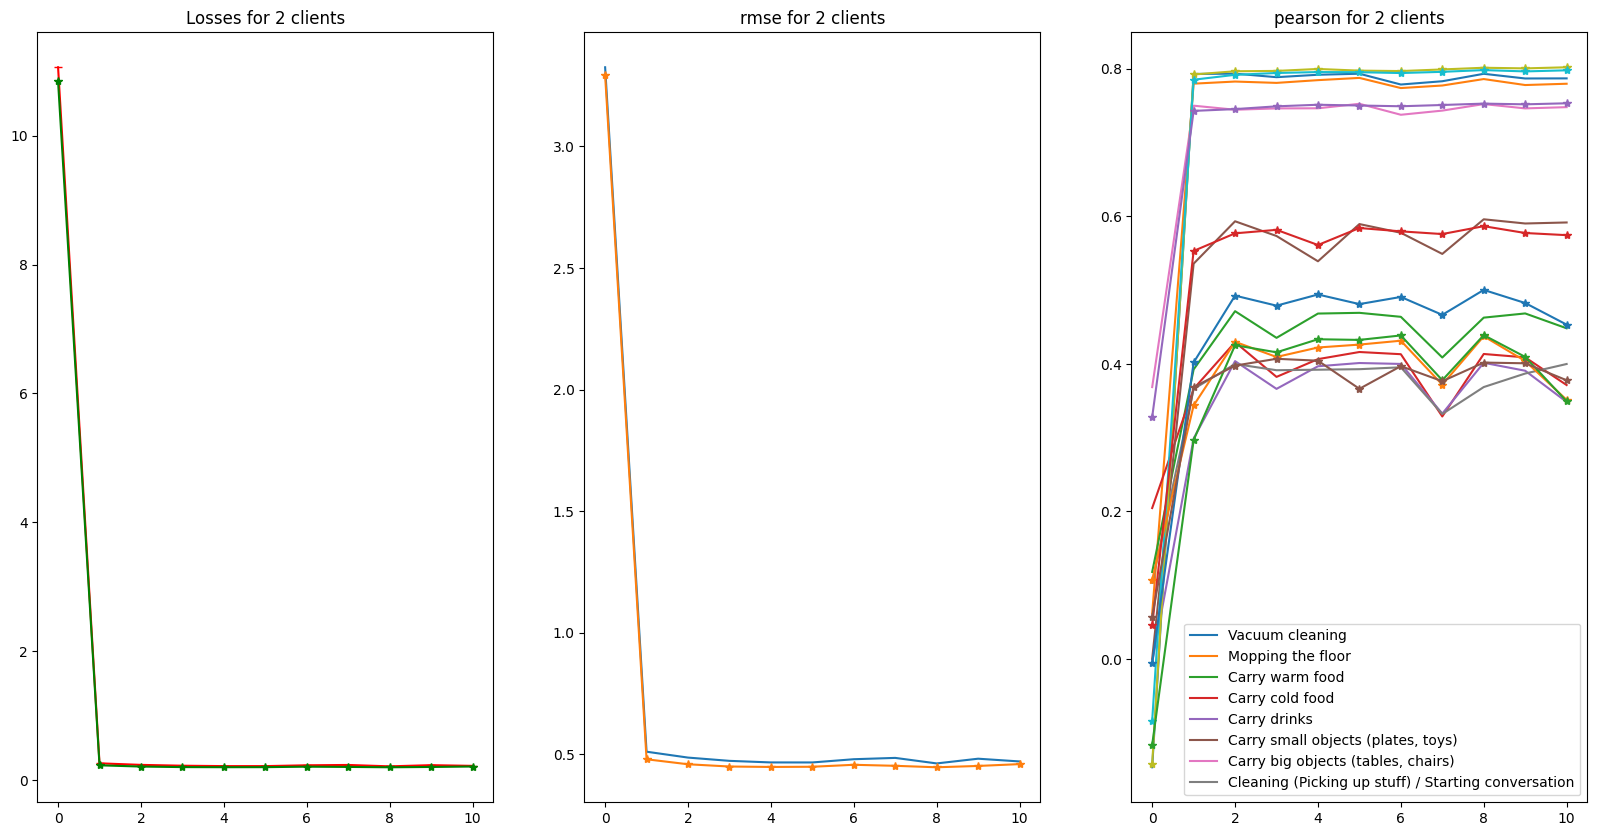

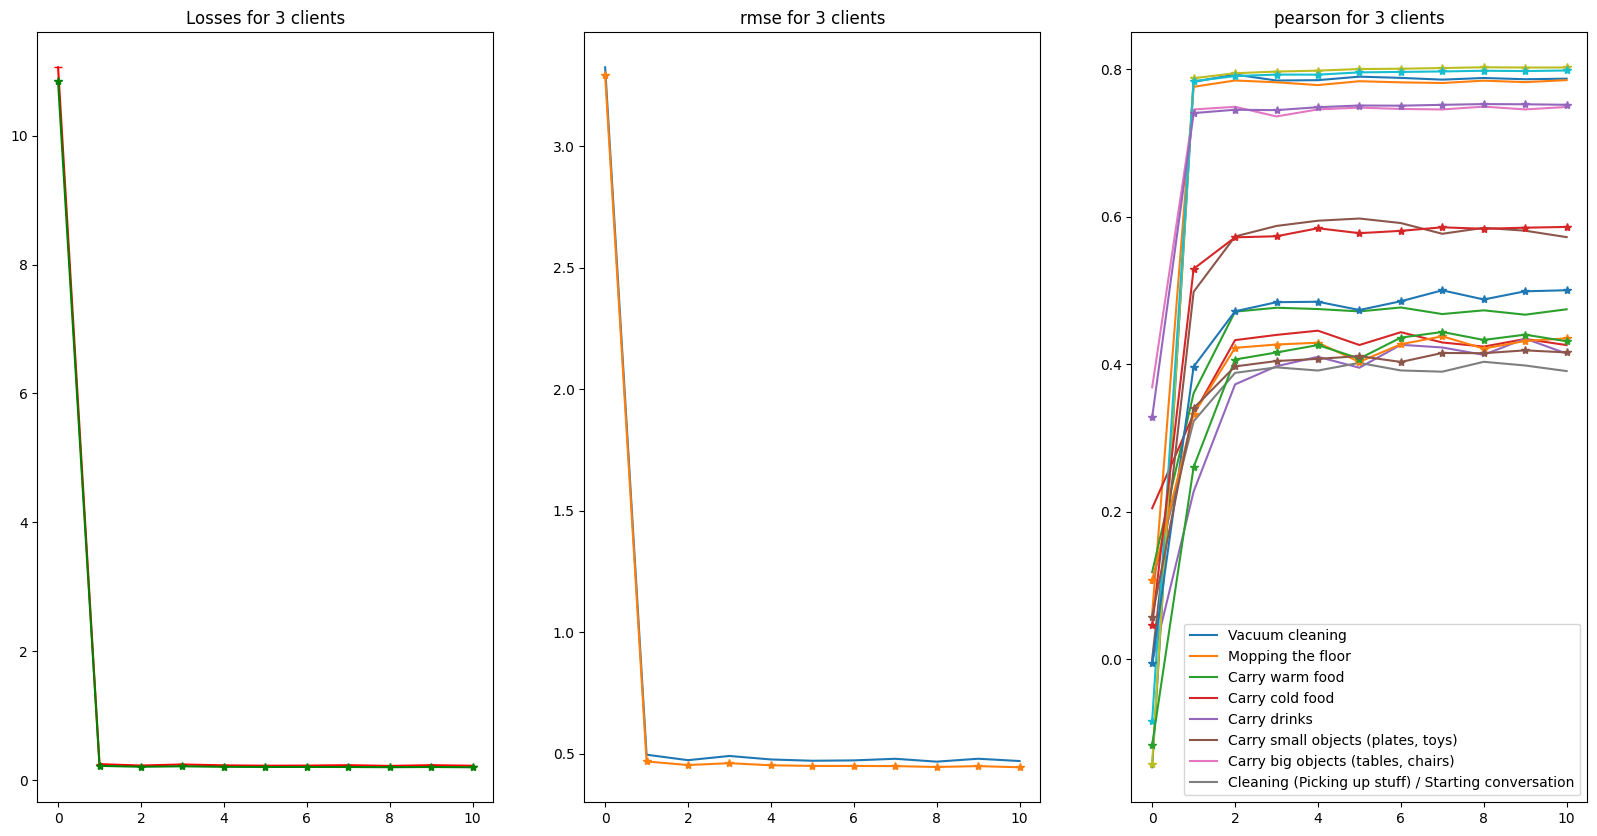

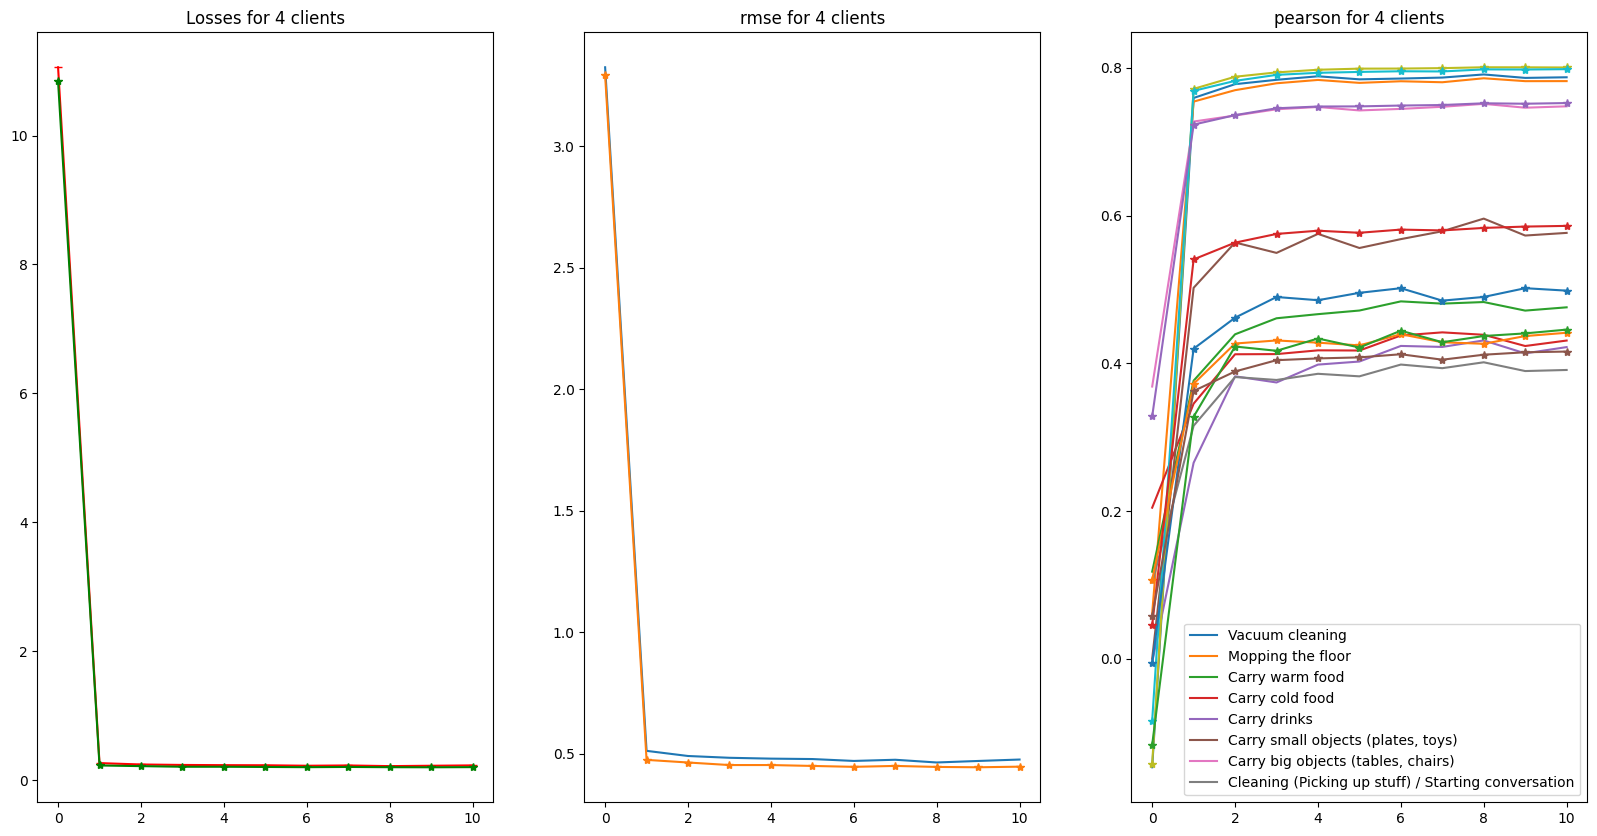

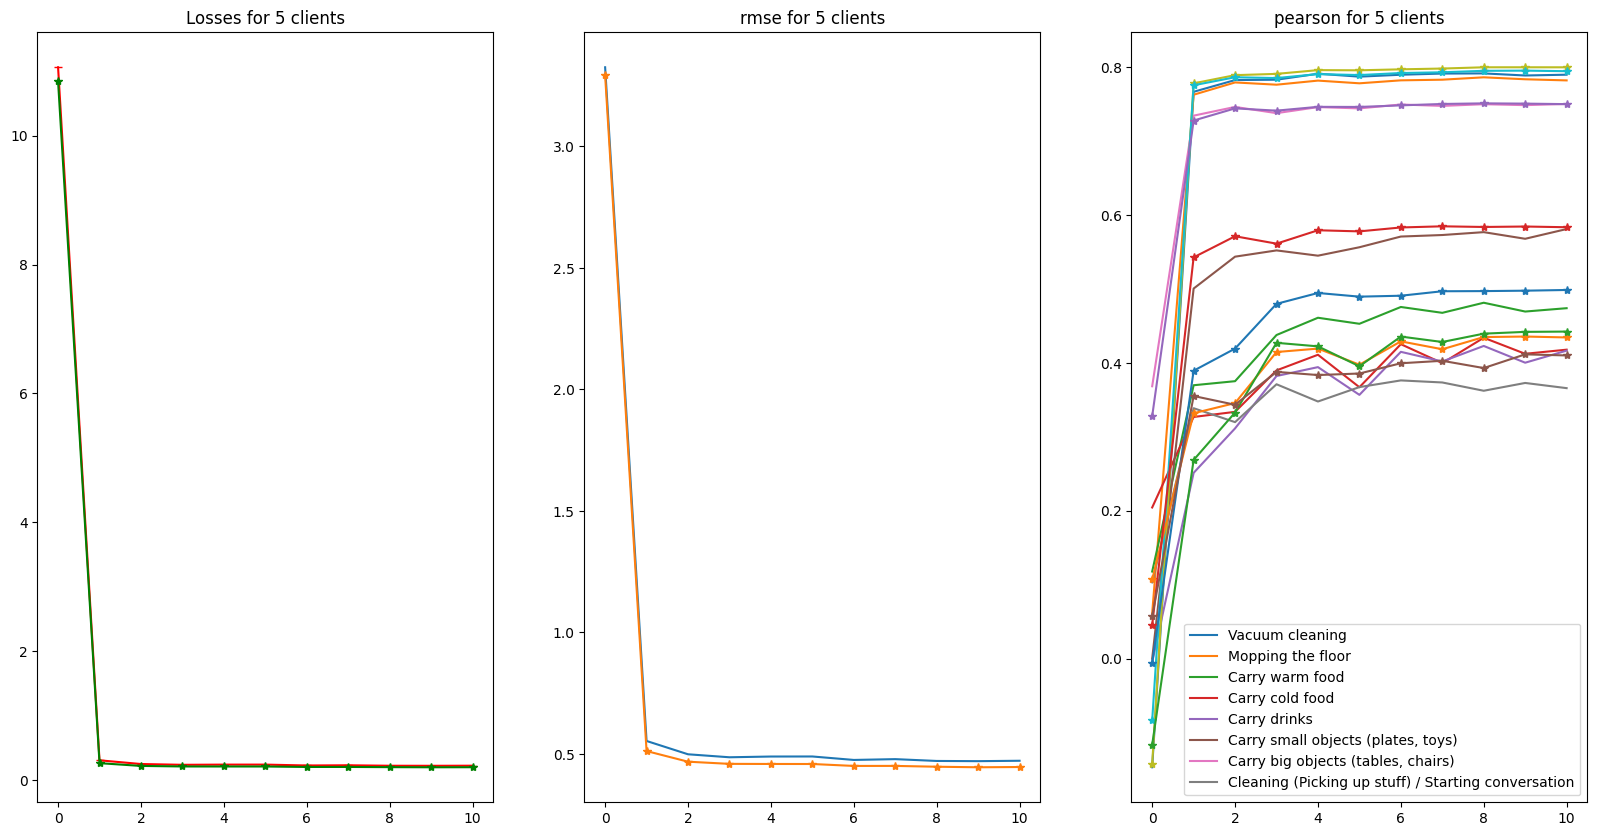

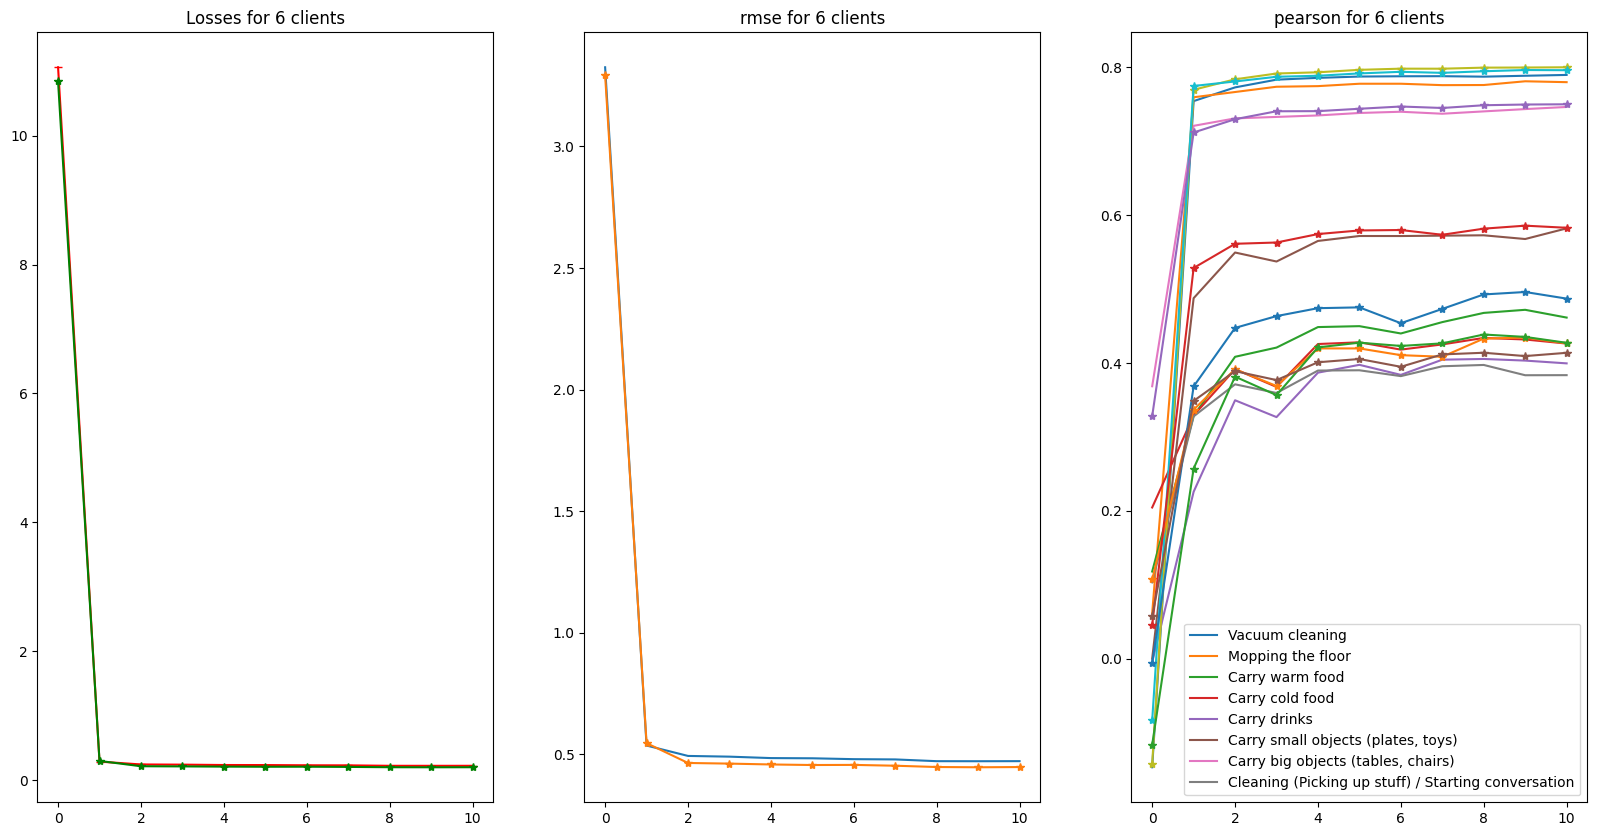

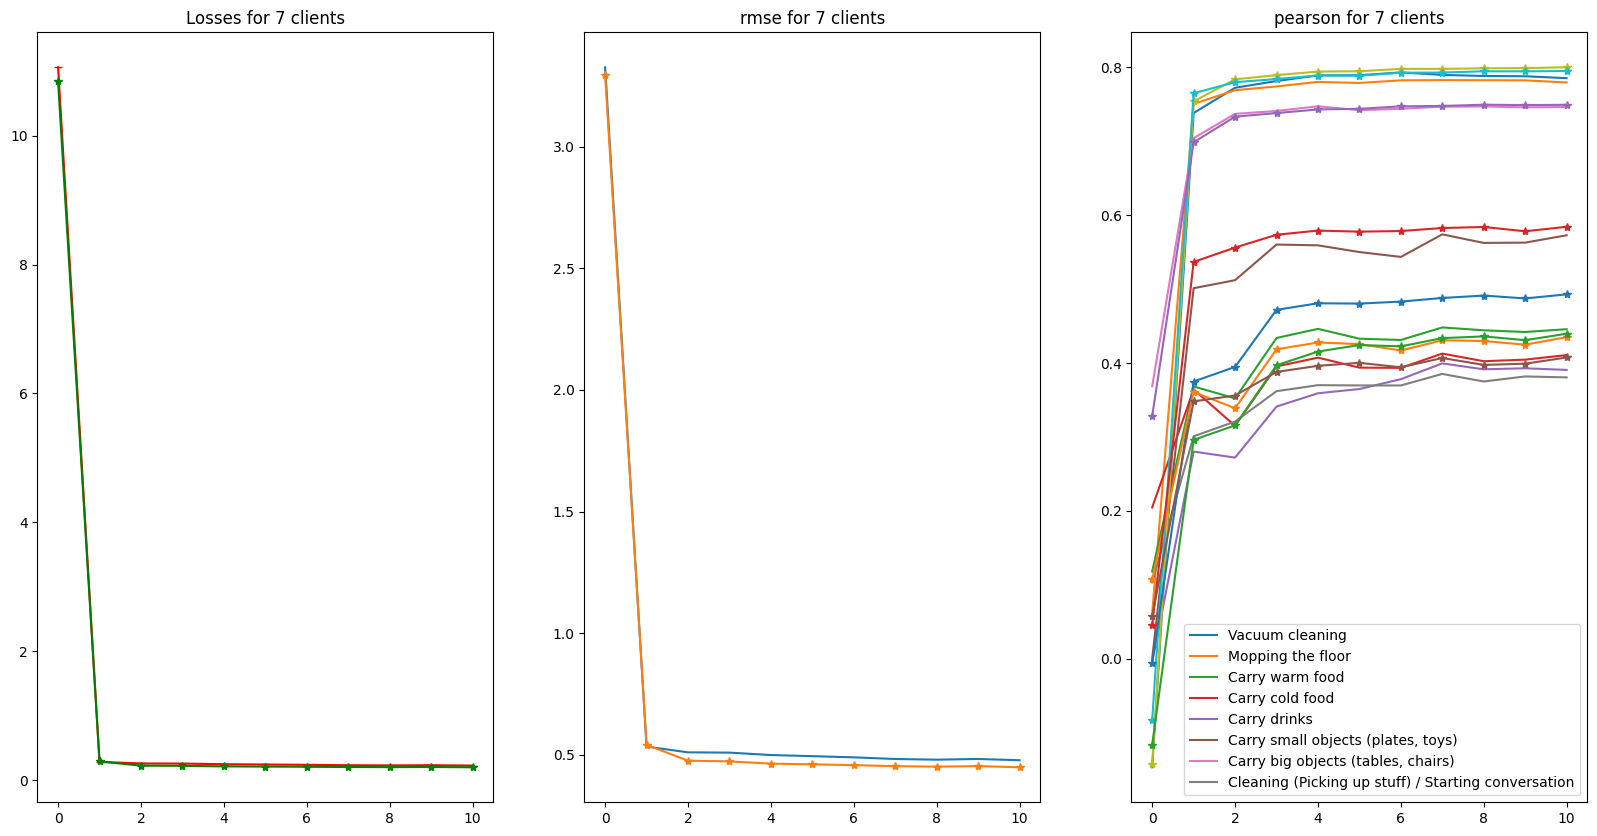

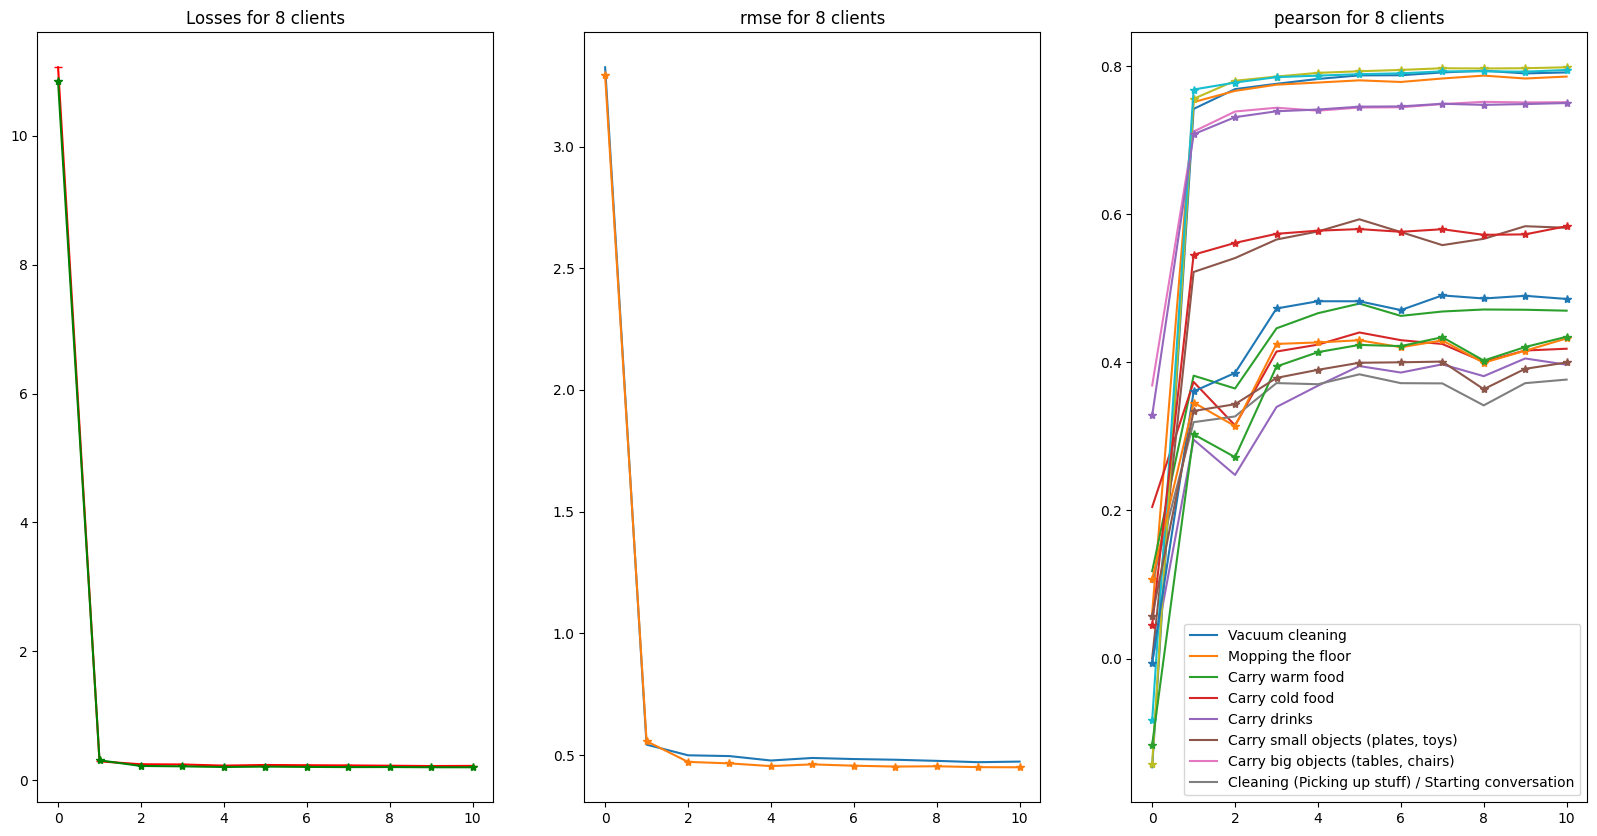

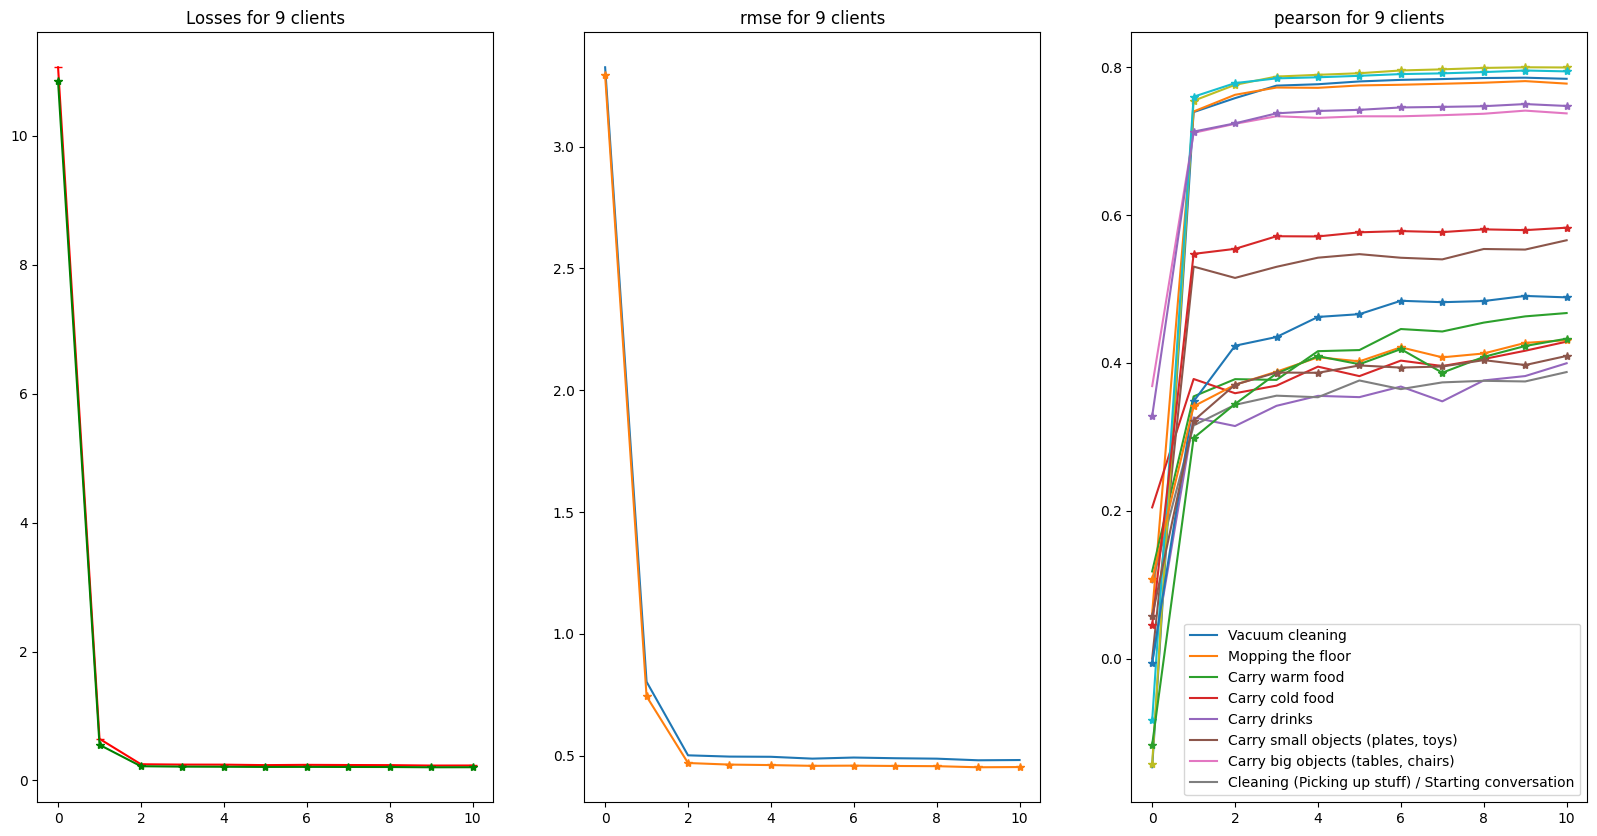

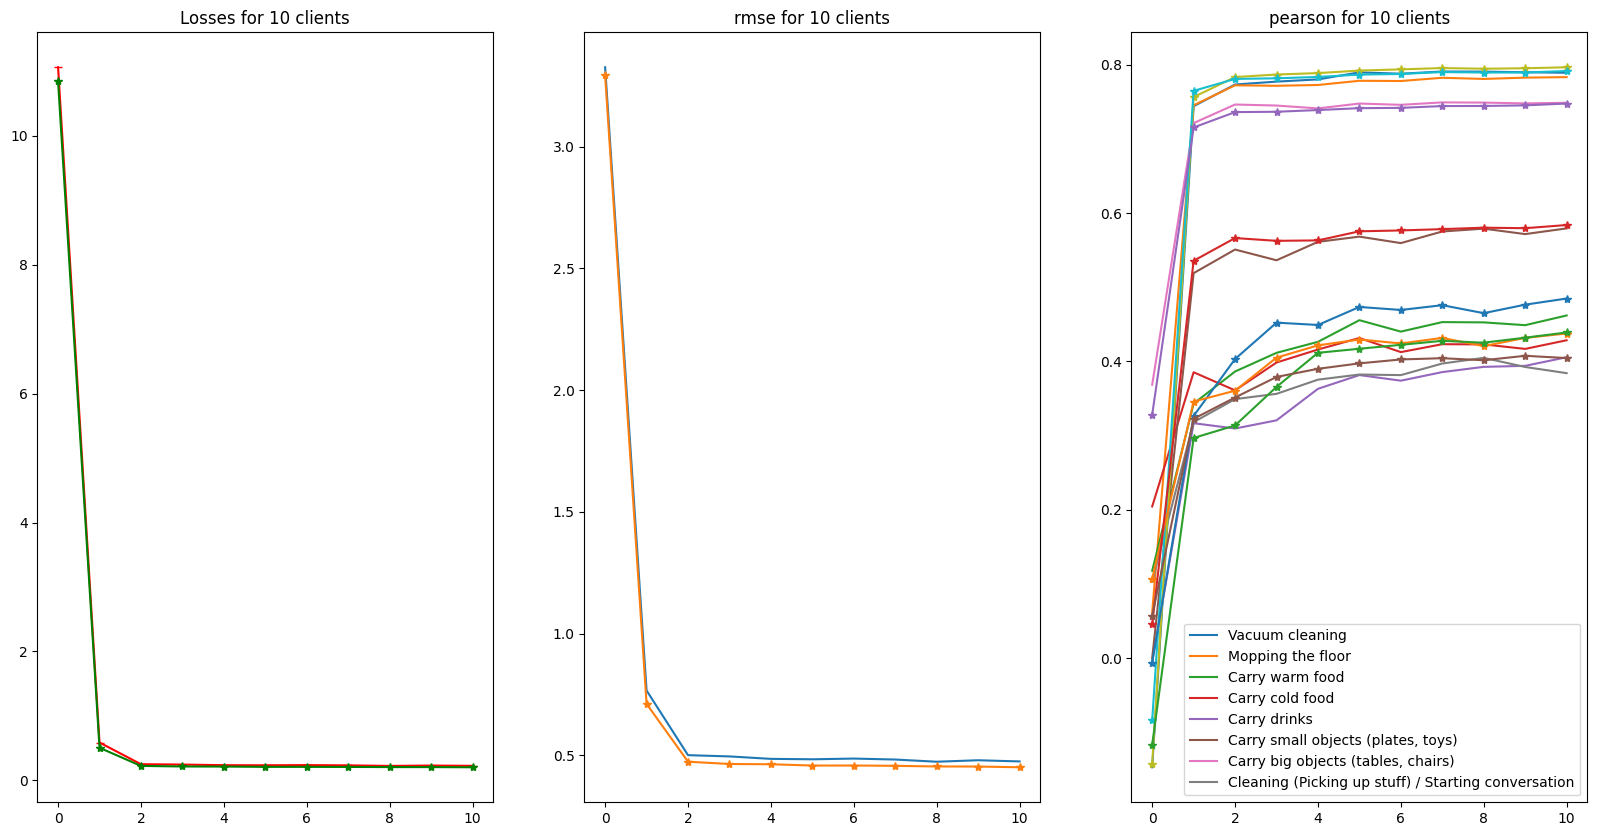

In [23]:
#for each client, plot losses, rmse in separate graphs and pearson of each label in a single graph with all labels marked in the legend
import matplotlib.pyplot as plt
for i in range(len(results)):
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.plot(results[i]['Losses'], marker='_', color='red')
    plt.title("Losses for "+str(results[i]['clients'])+" clients")
    # plt.figure(figsize=(10,5))
    plt.plot(results_train[i]['Losses'],marker='*', color='green')
    plt.subplot(1,3,2)
    plt.plot(results[i]['rmse'])
    plt.plot(results_train[i]['rmse'], marker='*')

    plt.title("rmse for "+str(results[i]['clients'])+" clients")
    plt.subplot(1,3,3)
    for j in range(len(y_labels)):
        plt.plot(results[i]['pearson'][y_labels[j]])
    for j in range(len(y_labels)):
        plt.plot(results_train[i]['pearson'][y_labels[j]],marker='*')
    plt.title("pearson for "+str(results[i]['clients'])+" clients")
    plt.legend(y_labels)
    plt.savefig(f"{path}/{i+2}/{strat}.png")


In [24]:
import json
for i in range(len(results)):
    with open(f"{path}/{i+2}/{strat}/"+str(results[i]['clients'])+"clients.json", "w") as outfile:
        json.dump(results[i], outfile)


In [25]:
#load the results from the path "/results/fedAvgN" and create a dataframe with losses, rmse and average pearson of every label for each client
import json
import os
results=[]
for i in range(2,11):
    with open(f"{path}/{i}/{strat}/"+str(i)+"clients.json") as json_file:
        results.append(json.load(json_file))
import pandas as pd
df=pd.DataFrame(results)
df.head()

,clients,Losses,rmse,pearson
0,2,"[11.060606956481934, 0.2614651620388031, 0.237...","[3.325749158859253, 0.511336624622345, 0.48716...","{'Vacuum cleaning': [-0.1468226751843182, 0.79..."
1,3,"[11.060606956481934, 0.2467912882566452, 0.224...","[3.325749158859253, 0.4967809319496155, 0.4742...","{'Vacuum cleaning': [-0.1468226751843182, 0.78..."
2,4,"[11.060606956481934, 0.26219427585601807, 0.24...","[3.325749158859253, 0.5120490789413452, 0.4908...","{'Vacuum cleaning': [-0.1468226751843182, 0.75..."
3,5,"[11.060606956481934, 0.30641746520996094, 0.24...","[3.325749158859253, 0.5535498857498169, 0.4988...","{'Vacuum cleaning': [-0.1468226751843182, 0.76..."
4,6,"[11.060606956481934, 0.2868264317512512, 0.242...","[3.325749158859253, 0.5355618000030518, 0.4927...","{'Vacuum cleaning': [-0.1468226751843182, 0.75..."


In [26]:
df=pd.DataFrame(results)


In [27]:
#add a new column named pearson_avg
df['pearson_avg']=[[] for i in range(len(df))]


In [28]:
df.head()

,clients,Losses,rmse,pearson,pearson_avg
0,2,"[11.060606956481934, 0.2614651620388031, 0.237...","[3.325749158859253, 0.511336624622345, 0.48716...","{'Vacuum cleaning': [-0.1468226751843182, 0.79...",[]
1,3,"[11.060606956481934, 0.2467912882566452, 0.224...","[3.325749158859253, 0.4967809319496155, 0.4742...","{'Vacuum cleaning': [-0.1468226751843182, 0.78...",[]
2,4,"[11.060606956481934, 0.26219427585601807, 0.24...","[3.325749158859253, 0.5120490789413452, 0.4908...","{'Vacuum cleaning': [-0.1468226751843182, 0.75...",[]
3,5,"[11.060606956481934, 0.30641746520996094, 0.24...","[3.325749158859253, 0.5535498857498169, 0.4988...","{'Vacuum cleaning': [-0.1468226751843182, 0.76...",[]
4,6,"[11.060606956481934, 0.2868264317512512, 0.242...","[3.325749158859253, 0.5355618000030518, 0.4927...","{'Vacuum cleaning': [-0.1468226751843182, 0.75...",[]


In [29]:
y_labels=list(df['pearson'][0].keys())

for i in range(df.shape[0]):
    li=[]
    for k in range(10):
        sum=0
        for j in range(len(y_labels)):
            sum=sum+df['pearson'][i][y_labels[j]][k]
        sum=sum/10
        li.append(sum)
    df['pearson_avg'][i]=li



/tmp/ipykernel_282019/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_282019/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_282019/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_282019/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [30]:
for i in range(df.shape[0]):
  # mini=min(df['Losses'][i])
  # idx=df['Losses'][i].index(mini)
  # print(idx)
  idx=-1
  df['Losses'][i]=df['Losses'][i][idx]
  df['rmse'][i]=df['rmse'][i][idx]
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]


/tmp/ipykernel_282019/3851578825.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Losses'][i]=df['Losses'][i][idx]
/tmp/ipykernel_282019/3851578825.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rmse'][i]=df['rmse'][i][idx]
/tmp/ipykernel_282019/3851578825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]
/tmp/ipykernel_282019/3851578825.py:6: SettingWithCopyWarning: 
A v

In [31]:
df

,clients,Losses,rmse,pearson,pearson_avg
0,2,0.222124,0.4713,"{'Vacuum cleaning': [-0.1468226751843182, 0.79...",0.455748
1,3,0.221606,0.470751,"{'Vacuum cleaning': [-0.1468226751843182, 0.78...",0.463011
2,4,0.226853,0.476291,"{'Vacuum cleaning': [-0.1468226751843182, 0.75...",0.458597
3,5,0.222923,0.472147,"{'Vacuum cleaning': [-0.1468226751843182, 0.76...",0.454611
4,6,0.222136,0.471313,"{'Vacuum cleaning': [-0.1468226751843182, 0.75...",0.457221
5,7,0.228276,0.477783,"{'Vacuum cleaning': [-0.1468226751843182, 0.73...",0.450071
6,8,0.223619,0.472884,"{'Vacuum cleaning': [-0.1468226751843182, 0.74...",0.457111
7,9,0.232408,0.482087,"{'Vacuum cleaning': [-0.1468226751843182, 0.73...",0.449782
8,10,0.225853,0.475239,"{'Vacuum cleaning': [-0.1468226751843182, 0.74...",0.454445


In [32]:
df.drop(['pearson'], axis=1, inplace=True)

In [33]:
for i in range(df.shape[0]):
  try:
    data=pd.read_csv(f"{path}/clients{i+2}.csv")
    data.drop(["Unnamed: 0"], axis=1, inplace=True)
  except:
    data=pd.DataFrame(columns=["methods", "Loss", "RMSE", "PCC"])
  # data=data.append(pd.Series(["FedAvg_NoAug",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]]), ignore_index=True)
  data=pd.concat([data,pd.Series([f"{strat}",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]] , index=data.columns ).to_frame().T])
  data.to_csv(f"{path}/clients{i+2}.csv")

